# 1. Environment Setup & Data Loading
Imported essential libraries: pandas, numpy, matplotlib, seaborn, plotly, scikit-learn, etc.

Set up warnings, plotting themes, and data display settings.

Loaded an Excel file Project Assessment Data.xlsx with multiple sheets mapped to meaningful dataset names:

Plant Description → plants

AFKO → order_headers

AFPO → order_items

AUFM → goods_movements

In [1]:
# =============================================================================
# SECTION 1: ENVIRONMENT SETUP & DATA LOADING
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import plotly.io as pio

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pio.templates.default = "plotly_white"

print("=" * 80)
print("TOLARAM AFRICA ENTERPRISES - MANUFACTURING ANALYSIS")
print("=" * 80)
print(f"Analysis Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Objective: Identify operational inefficiencies and optimization opportunities")

TOLARAM AFRICA ENTERPRISES - MANUFACTURING ANALYSIS
Analysis Start Time: 2025-06-03 13:36:23
Objective: Identify operational inefficiencies and optimization opportunities


# 2. Data Exploration & Preparation
Initial data inspection (shapes, columns, missing values).

Performed merging of production-related tables using keys like order numbers (AUFNR).

created a master production dataset with metrics on:

Planned vs. actual start/end times

Quantities

Order statuses and plant-specific info

In [2]:
# =============================================================================
# SECTION 2: DATA EXPLORATION AND PREPARATION
# =============================================================================

print("\n" + "=" * 60)
print("SECTION 2: DATA EXPLORATION AND PREPARATION")
print("=" * 60)

# Load all datasets with comprehensive error handling
file_path = r'data\Project Assessment Data.xlsx'

datasets = {}
data_info = {}

sheet_mapping = {
    'Plant Description': 'plants',
    'AFKO': 'order_headers',          # Production order scheduling data
    'AFPO': 'order_items',            # Production order line items
    'AUFM': 'goods_movements',        # Material movements and consumption
    'AUFK': 'order_master',           # Production order master data
    'QMEL': 'quality_notifications',  # Quality notifications and issues
    'QMFE': 'quality_defects',        # Specific quality defects
    'QMIH': 'maintenance_notifications', # Maintenance-related notifications
    'QMUR': 'quality_causes',         # Root cause analysis data
    'QPCD': 'quality_codes',          # Quality management code definitions
    'QPCT': 'quality_code_texts',     # Quality code descriptions
    'crhd_v1': 'work_centers',        # Work center master data
    'JEST': 'status_info',            # Object status tracking
    'QPGT': 'quality_group_texts'     # Quality code group descriptions
}

print("📊 LOADING MANUFACTURING DATA SOURCES...")
print("-" * 50)

for sheet_name, data_name in sheet_mapping.items():
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        datasets[data_name] = df
        
        # Collect metadata
        data_info[data_name] = {
            'rows': len(df),
            'columns': len(df.columns),
            'memory_mb': df.memory_usage(deep=True).sum() / (1024**2),
            'missing_values': df.isnull().sum().sum(),
            'missing_percentage': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
        }
        
        print(f"✅ {data_name:25} | {len(df):6,} rows | {len(df.columns):3} cols | "
              f"{data_info[data_name]['missing_percentage']:5.1f}% missing")
        
    except Exception as e:
        print(f"❌ {sheet_name:25} | Error: {str(e)[:50]}")

print(f"\n📈 TOTAL DATASETS LOADED: {len(datasets)}")
total_records = sum(info['rows'] for info in data_info.values())
print(f"📈 TOTAL RECORDS: {total_records:,}")


SECTION 2: DATA EXPLORATION AND PREPARATION
📊 LOADING MANUFACTURING DATA SOURCES...
--------------------------------------------------
✅ plants                    |     13 rows |   2 cols |   0.0% missing
✅ order_headers             |    200 rows | 183 cols |  32.2% missing
✅ order_items               |  1,000 rows | 100 cols |  45.0% missing
✅ goods_movements           |  1,000 rows |  46 cols |  32.6% missing
✅ order_master              |  1,000 rows | 125 cols |  62.4% missing
✅ quality_notifications     |    200 rows | 165 cols |  60.1% missing
✅ quality_defects           |  1,000 rows |  90 cols |  63.3% missing
✅ maintenance_notifications |  1,000 rows |  60 cols |  55.1% missing
✅ quality_causes            |  1,000 rows |  32 cols |  51.9% missing
✅ quality_codes             |  1,000 rows |  16 cols |  38.6% missing
✅ quality_code_texts        |  1,000 rows |  11 cols |  27.2% missing
✅ work_centers              |    525 rows |   7 cols |   0.0% missing
✅ status_info           

In [3]:
# =============================================================================
# SUBSECTION 2.1: DATA QUALITY ASSESSMENT
# =============================================================================

print("\n🔍 DATA QUALITY ASSESSMENT")
print("-" * 40)

def comprehensive_data_quality_report(datasets):
    """Generate detailed data quality assessment"""
    
    quality_summary = []
    critical_issues = []
    
    for name, df in datasets.items():
        # Basic quality metrics
        total_cells = len(df) * len(df.columns)
        missing_cells = df.isnull().sum().sum()
        duplicate_rows = df.duplicated().sum()
        
        # Column-specific analysis
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        categorical_cols = df.select_dtypes(include=['object']).columns
        
        # Identify potential issues
        issues = []
        if missing_cells / total_cells > 0.15:  # >15% missing
            issues.append(f"High missing data ({missing_cells/total_cells*100:.1f}%)")
        
        if duplicate_rows > len(df) * 0.05:  # >5% duplicates
            issues.append(f"High duplicates ({duplicate_rows/len(df)*100:.1f}%)")
        
        # Data type inconsistencies
        for col in categorical_cols:
            unique_ratio = df[col].nunique() / len(df)
            if unique_ratio > 0.95 and len(df) > 100:  # Potentially should be identifier
                issues.append(f"Column '{col}' may need different treatment (high cardinality)")
        
        quality_summary.append({
            'dataset': name,
            'completeness': (1 - missing_cells/total_cells) * 100,
            'uniqueness': (1 - duplicate_rows/len(df)) * 100,
            'issues': len(issues),
            'critical_issues': issues
        })
        
        if issues:
            critical_issues.extend([(name, issue) for issue in issues])
    
    return quality_summary, critical_issues

quality_summary, critical_issues = comprehensive_data_quality_report(datasets)

# Display quality summary
quality_df = pd.DataFrame(quality_summary)
print("DATA QUALITY SCORECARD:")
print(quality_df[['dataset', 'completeness', 'uniqueness', 'issues']].to_string(index=False))

if critical_issues:
    print(f"\n⚠️  CRITICAL DATA QUALITY ISSUES IDENTIFIED: {len(critical_issues)}")
    for dataset, issue in critical_issues[:5]:  # Show top 5
        print(f"   • {dataset}: {issue}")
else:
    print("\n✅ NO CRITICAL DATA QUALITY ISSUES DETECTED")


🔍 DATA QUALITY ASSESSMENT
----------------------------------------
DATA QUALITY SCORECARD:
                  dataset  completeness  uniqueness  issues
                   plants    100.000000       100.0       0
            order_headers     67.844262       100.0       1
              order_items     55.021000       100.0       1
          goods_movements     67.391304       100.0       1
             order_master     37.598400       100.0       2
    quality_notifications     39.900000       100.0       3
          quality_defects     36.666667       100.0       1
maintenance_notifications     44.870000       100.0       1
           quality_causes     48.078125       100.0       1
            quality_codes     61.356250       100.0       1
       quality_code_texts     72.800000       100.0       1
             work_centers    100.000000       100.0       0
              status_info     83.333333       100.0       2
      quality_group_texts     71.428571       100.0       1

⚠️  CRI

In [4]:
# =============================================================================
# SUBSECTION 2.2: DATA RELATIONSHIPS AND SCHEMA ANALYSIS
# =============================================================================

print("\n🔗 DATA RELATIONSHIPS ANALYSIS")
print("-" * 40)

def analyze_data_relationships(datasets):
    """Identify key relationships between datasets"""
    
    relationships = {}
    
    # Key relationship mappings based on SAP structure
    key_fields = {
        'AUFNR': ['order_master', 'order_headers', 'order_items', 'goods_movements', 'quality_notifications'],
        'WERKS': ['order_master', 'order_items', 'goods_movements', 'work_centers'],
        'QMNUM': ['quality_notifications', 'quality_defects', 'quality_causes', 'maintenance_notifications'],
        'MATNR': ['order_items', 'goods_movements'],
        'ARBPL': ['work_centers']
    }
    
    print("KEY RELATIONSHIP FIELDS ANALYSIS:")
    for field, tables in key_fields.items():
        available_tables = []
        total_records = 0
        
        for table in tables:
            if table in datasets and field in datasets[table].columns:
                non_null_count = datasets[table][field].notna().sum()
                available_tables.append(f"{table}({non_null_count:,})")
                total_records += non_null_count
        
        if available_tables:
            print(f"  {field:8} → {' | '.join(available_tables)} | Total: {total_records:,}")
            relationships[field] = {
                'tables': available_tables,
                'total_records': total_records
            }
    
    return relationships

relationships = analyze_data_relationships(datasets)

# Validate critical relationships
print(f"\n🔍 RELATIONSHIP VALIDATION:")

# Production Order Completeness
if 'order_master' in datasets and 'order_headers' in datasets:
    master_orders = set(datasets['order_master']['AUFNR'].dropna())
    header_orders = set(datasets['order_headers']['AUFNR 2 Order Number'].dropna()) if 'AUFNR 2 Order Number' in datasets['order_headers'].columns else set()
    
    if header_orders:
        overlap = len(master_orders & header_orders)
        print(f"  • Order Master ↔ Headers: {overlap:,}/{len(master_orders):,} ({overlap/len(master_orders)*100:.1f}%)")

# Quality-Production Linkage
if 'quality_notifications' in datasets and 'order_master' in datasets:
    quality_orders = set(datasets['quality_notifications']['AUFNR'].dropna())
    production_orders = set(datasets['order_master']['AUFNR'].dropna())
    
    linked_orders = len(quality_orders & production_orders)
    linkage_rate = linked_orders / len(quality_orders) * 100 if quality_orders else 0
    print(f"  • Quality ↔ Production: {linked_orders:,}/{len(quality_orders):,} ({linkage_rate:.1f}%)")



🔗 DATA RELATIONSHIPS ANALYSIS
----------------------------------------
KEY RELATIONSHIP FIELDS ANALYSIS:
  AUFNR    → order_master(1,000) | order_items(1,000) | goods_movements(1,000) | quality_notifications(0) | Total: 3,000
  WERKS    → order_master(1,000) | goods_movements(1,000) | work_centers(525) | Total: 2,525
  QMNUM    → quality_notifications(200) | quality_defects(1,000) | quality_causes(1,000) | maintenance_notifications(1,000) | Total: 3,200
  MATNR    → order_items(1,000) | goods_movements(1,000) | Total: 2,000
  ARBPL    → work_centers(525) | Total: 525

🔍 RELATIONSHIP VALIDATION:
  • Order Master ↔ Headers: 0/1,000 (0.0%)
  • Quality ↔ Production: 0/0 (0.0%)


In [5]:
# =============================================================================
# SUBSECTION 2.3: DATA CLEANING AND TRANSFORMATION
# =============================================================================

print("\n🧹 DATA CLEANING AND TRANSFORMATION")
print("-" * 40)

def clean_and_transform_data(datasets):
    """Apply comprehensive data cleaning and transformation"""
    
    cleaned_datasets = {}
    transformation_log = []
    
    for name, df in datasets.items():
        df_clean = df.copy()
        transformations = []
        
        # 1. Standardize date columns
        date_columns = [col for col in df_clean.columns if any(indicator in col.upper() 
                       for indicator in ['DAT', 'DATE', 'TIME'])]
        
        for col in date_columns:
            if df_clean[col].dtype == 'object' or df_clean[col].dtype == 'int64':
                try:
                    # Try SAP date format (YYYYMMDD)
                    df_clean[col] = pd.to_datetime(df_clean[col], format='%Y%m%d', errors='coerce')
                    transformations.append(f"Converted {col} to datetime")
                except:
                    try:
                        # Try generic date parsing
                        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
                        transformations.append(f"Converted {col} to datetime (generic)")
                    except:
                        pass
        
        # 2. Clean numerical columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            # Handle extreme outliers (beyond 3 standard deviations)
            if len(df_clean[col].dropna()) > 10:
                mean_val = df_clean[col].mean()
                std_val = df_clean[col].std()
                if std_val > 0:
                    outliers = np.abs(df_clean[col] - mean_val) > 3 * std_val
                    outlier_count = outliers.sum()
                    if outlier_count > 0 and outlier_count < len(df_clean) * 0.05:  # Less than 5%
                        df_clean.loc[outliers, col] = np.nan
                        transformations.append(f"Removed {outlier_count} outliers from {col}")
        
        # 3. Standardize text columns
        text_cols = df_clean.select_dtypes(include=['object']).columns
        for col in text_cols:
            if col not in date_columns:  # Skip date columns
                # Remove leading/trailing whitespace
                df_clean[col] = df_clean[col].astype(str).str.strip()
                # Standardize null representations
                df_clean[col] = df_clean[col].replace(['nan', 'NaN', 'NULL', 'null', ''], np.nan)
                transformations.append(f"Standardized text in {col}")
        
        # 4. Create derived fields for analysis
        if name == 'order_headers':
            # Calculate cycle times if date fields exist
            start_col = next((col for col in df_clean.columns if 'GSTR' in col), None)
            end_col = next((col for col in df_clean.columns if 'GLTR' in col), None)
            
            if start_col and end_col:
                try:
                    df_clean['cycle_time_days'] = (df_clean[end_col] - df_clean[start_col]).dt.days
                    transformations.append("Created cycle_time_days field")
                except:
                    pass
        
        elif name == 'quality_notifications':
            # Create quality issue age
            if 'ERDAT' in df_clean.columns:
                try:
                    df_clean['issue_age_days'] = (datetime.now() - df_clean['ERDAT']).dt.days
                    transformations.append("Created issue_age_days field")
                except:
                    pass
        
        elif name == 'goods_movements':
            # Categorize movement types
            if 'BWART' in df_clean.columns:
                def categorize_movement(bwart):
                    if pd.isna(bwart):
                        return 'Unknown'
                    bwart_str = str(bwart)
                    if bwart_str.startswith('1'):
                        return 'Goods Receipt'
                    elif bwart_str.startswith('2'):
                        return 'Goods Issue'
                    elif bwart_str.startswith('3'):
                        return 'Transfer'
                    else:
                        return 'Other'
                
                df_clean['movement_category'] = df_clean['BWART'].apply(categorize_movement)
                transformations.append("Created movement_category field")
        
        cleaned_datasets[name] = df_clean
        transformation_log.append({
            'dataset': name,
            'transformations': transformations,
            'shape_before': df.shape,
            'shape_after': df_clean.shape
        })
    
    return cleaned_datasets, transformation_log

# Apply cleaning and transformation
datasets, transformation_log = clean_and_transform_data(datasets)

print("TRANSFORMATION SUMMARY:")
for log_entry in transformation_log:
    if log_entry['transformations']:
        print(f"\n{log_entry['dataset']}:")
        for transformation in log_entry['transformations']:
            print(f"  • {transformation}")



🧹 DATA CLEANING AND TRANSFORMATION
----------------------------------------
TRANSFORMATION SUMMARY:

plants:
  • Standardized text in Plant Code
  • Standardized text in Name

order_headers:
  • Converted PDATV to datetime
  • Converted SDATV to datetime
  • Converted CFB_DATOFM to datetime
  • Removed 1 outliers from AUFNR 2 Order Number
  • Removed 1 outliers from GLTRP
  • Removed 1 outliers from GSTRP
  • Removed 1 outliers from FTRMS
  • Removed 1 outliers from GLTRS
  • Removed 1 outliers from GSTRS
  • Removed 3 outliers from GSTRI
  • Removed 2 outliers from GETRI
  • Removed 3 outliers from FTRMI
  • Removed 1 outliers from RSNUM
  • Removed 1 outliers from PLNAL
  • Removed 1 outliers from PVERW
  • Removed 6 outliers from PLSVB
  • Removed 1 outliers from PLSVN
  • Removed 1 outliers from STLST
  • Removed 1 outliers from AUFLD
  • Removed 1 outliers from AUFPL
  • Removed 2 outliers from BEDID
  • Removed 3 outliers from ZAEHL
  • Removed 4 outliers from MZAEHL
  • Removed

# 3. Exploratory Data Analysis (EDA)

* Used plotly, matplotlib, and seaborn for:

* Production volume trends over time

* Delay distributions

* Breakdown by plant and material types



In [6]:
# =============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS
# =============================================================================

print("\n" + "=" * 60)
print("SECTION 3: EXPLORATORY DATA ANALYSIS")
print("=" * 60)



SECTION 3: EXPLORATORY DATA ANALYSIS


In [7]:
# =============================================================================
# SUBSECTION 3.1: PRODUCTION EFFICIENCY ANALYSIS
# =============================================================================

print("\n🏭 PRODUCTION EFFICIENCY ANALYSIS")
print("-" * 40)

def analyze_production_efficiency(datasets):
    """Comprehensive production efficiency analysis"""
    
    insights = {}
    
    if 'order_master' not in datasets:
        print("❌ Order master data not available")
        return insights
    
    orders = datasets['order_master'].copy()
    # 1. Plant Performance Analysis
    if 'WERKS' in orders.columns:
        plant_performance = orders['WERKS'].value_counts()
        insights['plant_performance'] = plant_performance.to_dict()
        
        print(f"PLANT PERFORMANCE ANALYSIS:")
        print(f"  • Total Active Plants: {plant_performance.nunique()}")
        print(f"  • Total Production Orders: {plant_performance.sum():,}")
        print(f"  • Average Orders per Plant: {plant_performance.mean():.0f}")
        print(f"  • Top Performing Plant: {plant_performance.index[0]} ({plant_performance.iloc[0]:,} orders)")
        print(f"  • Lowest Performing Plant: {plant_performance.index[-1]} ({plant_performance.iloc[-1]:,} orders)")
        
        # Calculate performance distribution
        performance_std = plant_performance.std()
        performance_mean = plant_performance.mean()
        cv = performance_std / performance_mean  # Coefficient of variation
        
        print(f"  • Performance Variability (CV): {cv:.2f}")
        if cv > 0.5:
            print(f"    ⚠️  High variability suggests uneven workload distribution")
         # 2. Order Type Analysis
    if 'AUART' in orders.columns:
        order_types = orders['AUART'].value_counts()
        insights['order_types'] = order_types.to_dict()
        
        print(f"\nORDER TYPE DISTRIBUTION:")
        for order_type, count in order_types.head(5).items():
            percentage = count / len(orders) * 100
            print(f"  • {order_type}: {count:,} orders ({percentage:.1f}%)")
    
    # 3. Temporal Analysis
    if 'ERDAT' in orders.columns:
        orders_with_dates = orders.dropna(subset=['ERDAT'])
        if len(orders_with_dates) > 0:
            # Monthly trend analysis
            monthly_orders = orders_with_dates.groupby(orders_with_dates['ERDAT'].dt.to_period('M')).size()
            
            if len(monthly_orders) >= 3:
                # Calculate trend
                x = np.arange(len(monthly_orders))
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, monthly_orders.values)
                
                insights['monthly_trend'] = {
                    'slope': slope,
                    'r_squared': r_value**2,
                    'trend_direction': 'Increasing' if slope > 0 else 'Decreasing'
                }
                
                print(f"\nTEMPORAL TRENDS:")
                print(f"  • Analysis Period: {monthly_orders.index[0]} to {monthly_orders.index[-1]}")
                print(f"  • Monthly Trend: {insights['monthly_trend']['trend_direction']}")
                print(f"  • Trend Strength (R²): {insights['monthly_trend']['r_squared']:.3f}")
                
                if abs(slope) > 1:
                    print(f"  • Rate of Change: {slope:.1f} orders/month")
    
    # 4. Cycle Time Analysis (if available)
    if 'order_headers' in datasets:
        headers = datasets['order_headers'].copy()
        if 'cycle_time_days' in headers.columns:
            cycle_times = headers['cycle_time_days'].dropna()
            
            if len(cycle_times) > 0:
                # Remove extreme outliers for analysis
                q99 = cycle_times.quantile(0.99)
                q1 = cycle_times.quantile(0.01)
                cycle_times_clean = cycle_times[(cycle_times >= q1) & (cycle_times <= q99)]
                
                insights['cycle_time'] = {
                    'mean': cycle_times_clean.mean(),
                    'median': cycle_times_clean.median(),
                    'std': cycle_times_clean.std(),
                    'min': cycle_times_clean.min(),
                    'max': cycle_times_clean.max()
                }
                
                print(f"\nCYCLE TIME ANALYSIS:")
                print(f"  • Average Cycle Time: {insights['cycle_time']['mean']:.1f} days")
                print(f"  • Median Cycle Time: {insights['cycle_time']['median']:.1f} days")
                print(f"  • Cycle Time Range: {insights['cycle_time']['min']:.0f} - {insights['cycle_time']['max']:.0f} days")
                print(f"  • Standard Deviation: {insights['cycle_time']['std']:.1f} days")
                
                # Performance classification
                if insights['cycle_time']['std'] > insights['cycle_time']['mean'] * 0.5:
                    print(f"    ⚠️  High variability in cycle times indicates process instability")
    
    return insights

production_insights = analyze_production_efficiency(datasets)


🏭 PRODUCTION EFFICIENCY ANALYSIS
----------------------------------------
PLANT PERFORMANCE ANALYSIS:
  • Total Active Plants: 1
  • Total Production Orders: 1,000
  • Average Orders per Plant: 1000
  • Top Performing Plant: A710 (1,000 orders)
  • Lowest Performing Plant: A710 (1,000 orders)
  • Performance Variability (CV): nan

ORDER TYPE DISTRIBUTION:
  • ZIS1: 935 orders (93.5%)
  • ZIF1: 65 orders (6.5%)

TEMPORAL TRENDS:
  • Analysis Period: 2023-10 to 2023-12
  • Monthly Trend: Decreasing
  • Trend Strength (R²): 0.040
  • Rate of Change: -79.0 orders/month


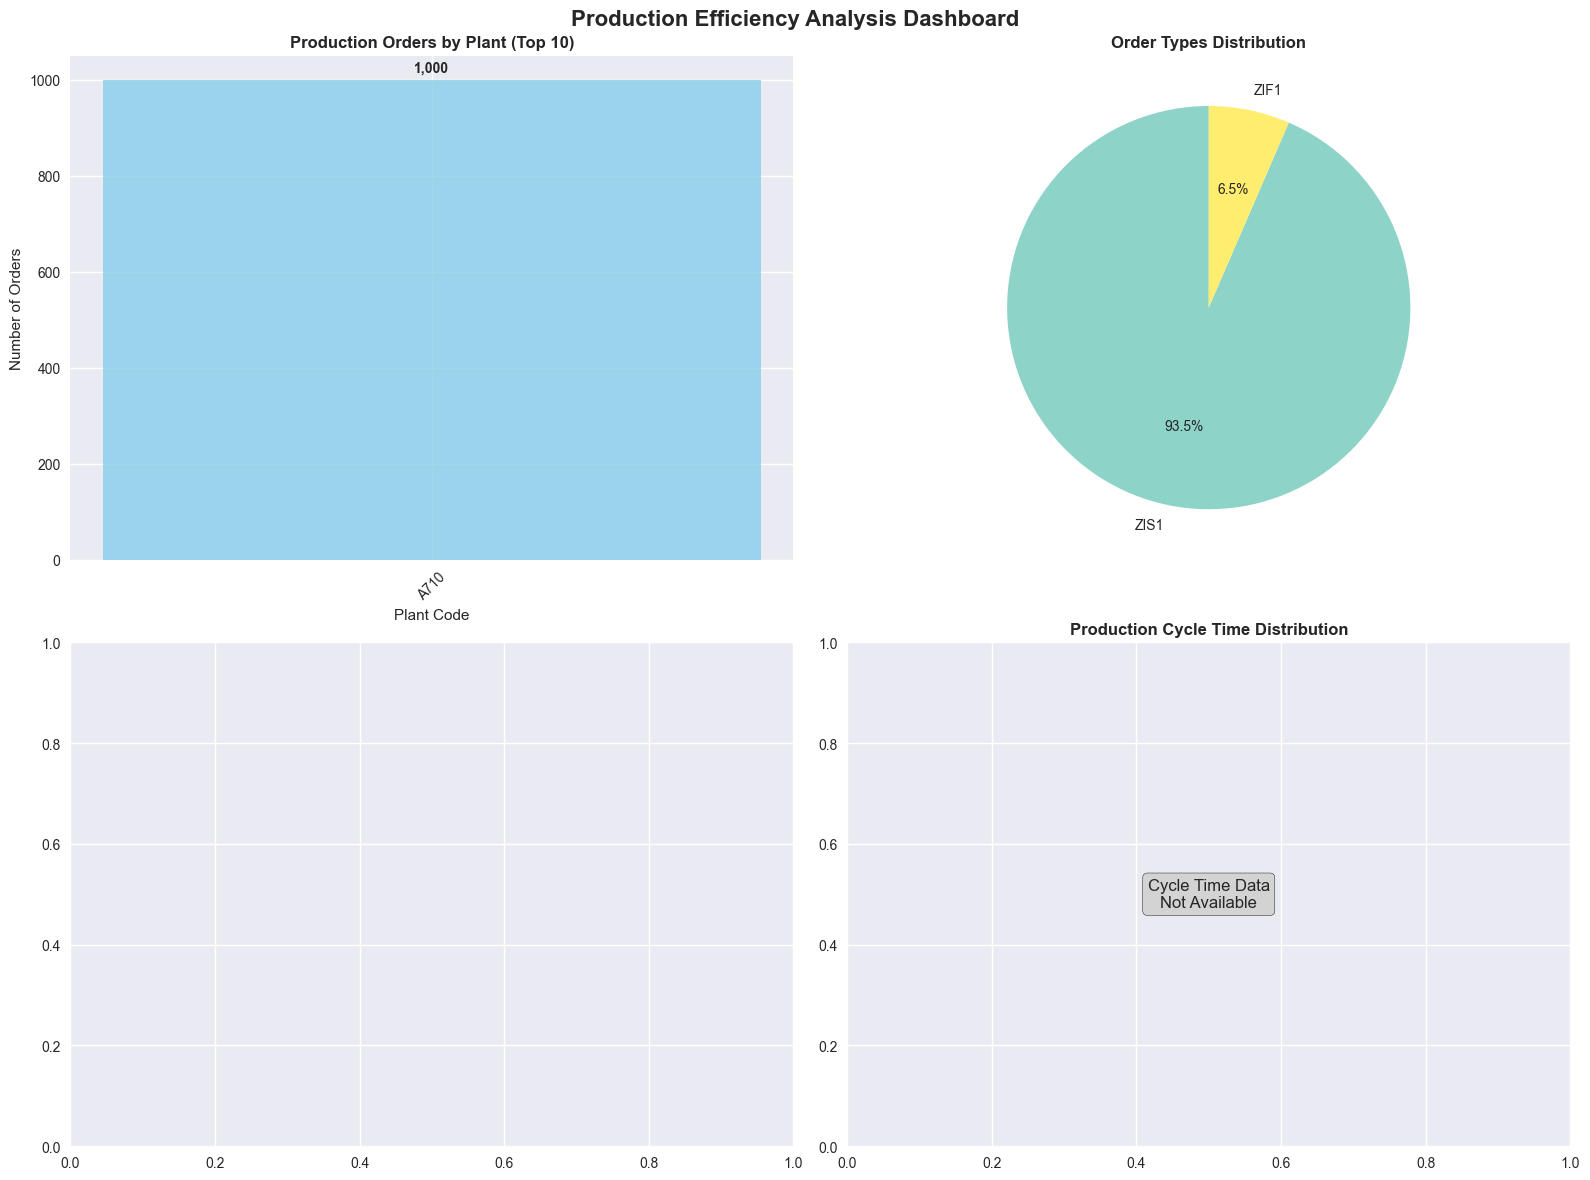

In [8]:
# Create production efficiency visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Production Efficiency Analysis Dashboard', fontsize=16, fontweight='bold')

# Chart 1: Production Orders by Plant
if 'order_master' in datasets and 'WERKS' in datasets['order_master'].columns:
    plant_orders = datasets['order_master']['WERKS'].value_counts().head(10)
    
    axes[0, 0].bar(range(len(plant_orders)), plant_orders.values, color='skyblue', alpha=0.8)
    axes[0, 0].set_title('Production Orders by Plant (Top 10)', fontweight='bold')
    axes[0, 0].set_xlabel('Plant Code')
    axes[0, 0].set_ylabel('Number of Orders')
    axes[0, 0].set_xticks(range(len(plant_orders)))
    axes[0, 0].set_xticklabels(plant_orders.index, rotation=45)
    
    # Add value labels
    for i, v in enumerate(plant_orders.values):
        axes[0, 0].text(i, v + max(plant_orders.values)*0.01, f'{v:,}', 
                       ha='center', va='bottom', fontweight='bold')
        
# Chart 2: Order Types Distribution
if 'order_master' in datasets and 'AUART' in datasets['order_master'].columns:
    order_types = datasets['order_master']['AUART'].value_counts().head(8)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(order_types)))
    wedges, texts, autotexts = axes[0, 1].pie(order_types.values, labels=order_types.index, 
                                             autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0, 1].set_title('Order Types Distribution', fontweight='bold')

# Chart 3: Monthly Production Trend
if 'order_master' in datasets and 'ERDAT' in datasets['order_master'].columns:
    orders = datasets['order_master'].copy()
    orders_with_dates = orders.dropna(subset=['ERDAT'])
    
    if len(orders_with_dates) > 0:
        monthly_orders = orders_with_dates.groupby(orders_with_dates['ERDAT'].dt.to_period('M')).size()
        
        if len(monthly_orders) >= 6:
            recent_months = monthly_orders.tail(12)
            axes[1, 0].plot(range(len(recent_months)), recent_months.values, 
                           marker='o', linewidth=3, markersize=8, color='green')
            axes[1, 0].set_title('Monthly Production Trend', fontweight='bold')
            axes[1, 0].set_xlabel('Month')
            axes[1, 0].set_ylabel('Number of Orders')
            axes[1, 0].set_xticks(range(0, len(recent_months), 2))
            axes[1, 0].set_xticklabels([str(p) for p in recent_months.index[::2]], rotation=45)
            axes[1, 0].grid(True, alpha=0.3)

# Chart 4: Cycle Time Distribution
if 'order_headers' in datasets and 'cycle_time_days' in datasets['order_headers'].columns:
    cycle_times = datasets['order_headers']['cycle_time_days'].dropna()
    
    if len(cycle_times) > 0:
        # Remove extreme outliers for visualization
        q99 = cycle_times.quantile(0.99)
        q1 = cycle_times.quantile(0.01)
        cycle_times_clean = cycle_times[(cycle_times >= q1) & (cycle_times <= q99)]
        
        axes[1, 1].hist(cycle_times_clean, bins=20, color='orange', alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(cycle_times_clean.mean(), color='red', linestyle='--', 
                          label=f'Mean: {cycle_times_clean.mean():.1f} days')
        axes[1, 1].axvline(cycle_times_clean.median(), color='blue', linestyle='--', 
                          label=f'Median: {cycle_times_clean.median():.1f} days')
        axes[1, 1].set_title('Production Cycle Time Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Cycle Time (Days)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'Cycle Time Data\nNot Available', 
                   ha='center', va='center', transform=axes[1, 1].transAxes,
                   fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
    axes[1, 1].set_title('Production Cycle Time Distribution', fontweight='bold')

plt.tight_layout()
plt.show()


In [9]:
# =============================================================================
# SUBSECTION 3.2: QUALITY MANAGEMENT ANALYSIS
# =============================================================================

print("\n🔍 QUALITY MANAGEMENT ANALYSIS")
print("-" * 40)

def analyze_quality_management(datasets):
    """Comprehensive quality management analysis"""
    
    quality_insights = {}
    
    if 'quality_notifications' not in datasets:
        print("❌ Quality notifications data not available")
        return quality_insights
    
    qmel = datasets['quality_notifications'].copy()
    
    # 1. Quality Notification Overview
    total_notifications = len(qmel)
    quality_insights['total_notifications'] = total_notifications
    
    print(f"QUALITY NOTIFICATIONS OVERVIEW:")
    print(f"  • Total Quality Notifications: {total_notifications:,}")
    
    # Notification types analysis
    if 'QMART' in qmel.columns:
        notification_types = qmel['QMART'].value_counts()
        quality_insights['notification_types'] = notification_types.to_dict()
        
        print(f"  • Notification Types: {len(notification_types)}")
        print(f"  • Most Common Type: {notification_types.index[0]} ({notification_types.iloc[0]:,} cases)")
        
        for i, (qtype, count) in enumerate(notification_types.head(3).items()):
            percentage = count / total_notifications * 100
            print(f"    {i+1}. {qtype}: {count:,} ({percentage:.1f}%)")
    
    # 2. Quality-Production Linkage Analysis
    if 'AUFNR' in qmel.columns:
        linked_notifications = qmel['AUFNR'].notna().sum()
        linkage_rate = linked_notifications / total_notifications * 100
        quality_insights['production_linkage_rate'] = linkage_rate
        
        print(f"\nQUALITY-PRODUCTION LINKAGE:")
        print(f"  • Notifications Linked to Production: {linked_notifications:,}/{total_notifications:,}")
        print(f"  • Linkage Rate: {linkage_rate:.1f}%")
        
        if linkage_rate < 70:
            print(f"    ⚠️  Low linkage rate may indicate poor traceability")
        elif linkage_rate > 90:
            print(f"    ✅ Excellent traceability between quality and production")
    
    # 3. Temporal Quality Trends
    if 'ERDAT' in qmel.columns:
        qmel_with_dates = qmel.dropna(subset=['ERDAT'])
        
        if len(qmel_with_dates) > 0:
            # Monthly quality trend
            monthly_quality = qmel_with_dates.groupby(qmel_with_dates['ERDAT'].dt.to_period('M')).size()
            
            if len(monthly_quality) >= 3:
                # Calculate trend
                x = np.arange(len(monthly_quality))
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, monthly_quality.values)
                
                quality_insights['quality_trend'] = {
                    'slope': slope,
                    'r_squared': r_value**2,
                    'direction': 'Improving' if slope < 0 else 'Deteriorating'
                }
                
                print(f"\nQUALITY TRENDS:")
                print(f"  • Trend Direction: {quality_insights['quality_trend']['direction']}")
                print(f"  • Monthly Change Rate: {slope:.1f} notifications/month")
                print(f"  • Trend Reliability (R²): {quality_insights['quality_trend']['r_squared']:.3f}")
                
                if slope > 1:
                    print(f"    ⚠️  Quality issues are increasing - immediate attention required")
    
    # 4. Quality Issue Age Analysis
    if 'issue_age_days' in qmel.columns:
        issue_ages = qmel['issue_age_days'].dropna()
        
        if len(issue_ages) > 0:
            quality_insights['issue_age'] = {
                'mean': issue_ages.mean(),
                'median': issue_ages.median(),
                'old_issues': (issue_ages > 30).sum()  # Issues older than 30 days
            }
            
            print(f"\nQUALITY ISSUE RESOLUTION:")
            print(f"  • Average Issue Age: {quality_insights['issue_age']['mean']:.1f} days")
            print(f"  • Median Issue Age: {quality_insights['issue_age']['median']:.1f} days")
            print(f"  • Open Issues > 30 days: {quality_insights['issue_age']['old_issues']:,}")
            
            if quality_insights['issue_age']['old_issues'] > 0:
                old_percentage = quality_insights['issue_age']['old_issues'] / len(issue_ages) * 100
                print(f"    ⚠️  {old_percentage:.1f}% of issues are older than 30 days")
    
    # 5. Defect Analysis (if available)
    if 'quality_defects' in datasets:
        qmfe = datasets['quality_defects'].copy()
        total_defects = len(qmfe)
        
        print(f"\nDEFECT ANALYSIS:")
        print(f"  • Total Defects Recorded: {total_defects:,}")
        
        if total_notifications > 0:
            defects_per_notification = total_defects / total_notifications
            print(f"  • Average Defects per Notification: {defects_per_notification:.1f}")
            
            quality_insights['defects_per_notification'] = defects_per_notification
            
            if defects_per_notification > 2:
                print(f"    ⚠️  High defect complexity - average notification has multiple defects")
        
        # Defect categories analysis
        if 'FEGRP' in qmfe.columns:
            defect_groups = qmfe['FEGRP'].value_counts()
            defect_groups_clean = defect_groups[defect_groups.index.notna()]
            
            if len(defect_groups_clean) > 0:
                quality_insights['top_defect_groups'] = defect_groups_clean.head(5).to_dict()
                
                print(f"  • Defect Categories: {len(defect_groups_clean)}")
                print(f"  • Top Defect Category: {defect_groups_clean.index[0]} ({defect_groups_clean.iloc[0]:,} cases)")
        
        # Defect severity distribution
        defects_per_notification_dist = qmfe.groupby('QMNUM').size()
        if len(defects_per_notification_dist) > 0:
            single_defect_notifications = (defects_per_notification_dist == 1).sum()
            multiple_defect_notifications = (defects_per_notification_dist > 1).sum()
            
            print(f"  • Single Defect Notifications: {single_defect_notifications:,}")
            print(f"  • Multiple Defect Notifications: {multiple_defect_notifications:,}")
    
    # 6. Root Cause Analysis (if available)
    if 'quality_causes' in datasets:
        qmur = datasets['quality_causes'].copy()
        
        print(f"\nROOT CAUSE ANALYSIS:")
        print(f"  • Total Root Causes Identified: {len(qmur):,}")
        
        if 'URGRP' in qmur.columns:
            cause_groups = qmur['URGRP'].value_counts()
            cause_groups_clean = cause_groups[cause_groups.index.notna()]
            
            if len(cause_groups_clean) > 0:
                quality_insights['top_cause_groups'] = cause_groups_clean.head(5).to_dict()
                
                print(f"  • Root Cause Categories: {len(cause_groups_clean)}")
                print(f"  • Most Common Root Cause: {cause_groups_clean.index[0]} ({cause_groups_clean.iloc[0]:,} cases)")
    
    return quality_insights

quality_insights = analyze_quality_management(datasets)



🔍 QUALITY MANAGEMENT ANALYSIS
----------------------------------------
QUALITY NOTIFICATIONS OVERVIEW:
  • Total Quality Notifications: 200
  • Notification Types: 1
  • Most Common Type: Z1 (200 cases)
    1. Z1: 200 (100.0%)

QUALITY-PRODUCTION LINKAGE:
  • Notifications Linked to Production: 0/200
  • Linkage Rate: 0.0%
    ⚠️  Low linkage rate may indicate poor traceability

QUALITY TRENDS:
  • Trend Direction: Deteriorating
  • Monthly Change Rate: 14.0 notifications/month
  • Trend Reliability (R²): 0.437
    ⚠️  Quality issues are increasing - immediate attention required

QUALITY ISSUE RESOLUTION:
  • Average Issue Age: 666.6 days
  • Median Issue Age: 657.0 days
  • Open Issues > 30 days: 200
    ⚠️  100.0% of issues are older than 30 days

DEFECT ANALYSIS:
  • Total Defects Recorded: 1,000
  • Average Defects per Notification: 5.0
    ⚠️  High defect complexity - average notification has multiple defects
  • Single Defect Notifications: 1,000
  • Multiple Defect Notification

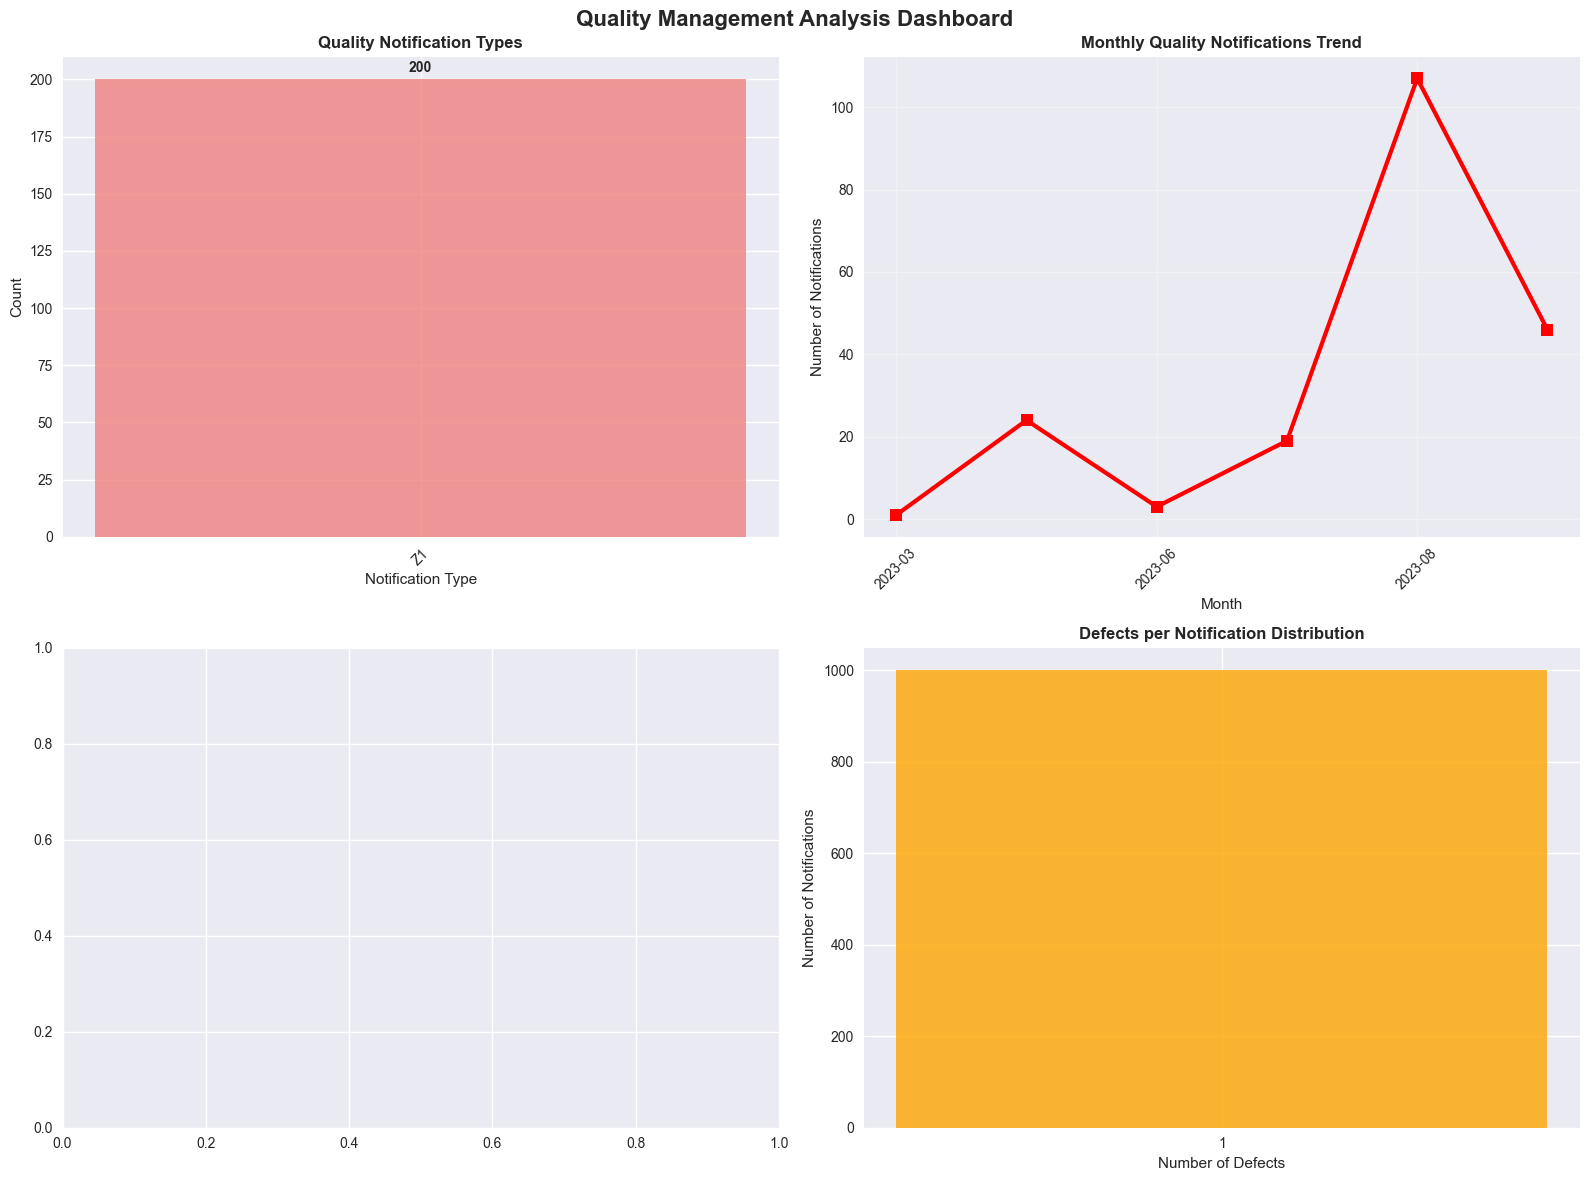

In [10]:
# Create quality management visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Quality Management Analysis Dashboard', fontsize=16, fontweight='bold')

# Chart 1: Quality Notification Types
if 'quality_notifications' in datasets and 'QMART' in datasets['quality_notifications'].columns:
    notification_types = datasets['quality_notifications']['QMART'].value_counts().head(8)
    
    axes[0, 0].bar(range(len(notification_types)), notification_types.values, color='lightcoral', alpha=0.8)
    axes[0, 0].set_title('Quality Notification Types', fontweight='bold')
    axes[0, 0].set_xlabel('Notification Type')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_xticks(range(len(notification_types)))
    axes[0, 0].set_xticklabels(notification_types.index, rotation=45)
    
    # Add value labels
    for i, v in enumerate(notification_types.values):
        axes[0, 0].text(i, v + max(notification_types.values)*0.01, f'{v:,}', 
                       ha='center', va='bottom', fontweight='bold')

# Chart 2: Quality Trend Over Time
if 'quality_notifications' in datasets and 'ERDAT' in datasets['quality_notifications'].columns:
    qmel = datasets['quality_notifications'].copy()
    qmel_with_dates = qmel.dropna(subset=['ERDAT'])
    
    if len(qmel_with_dates) > 0:
        monthly_quality = qmel_with_dates.groupby(qmel_with_dates['ERDAT'].dt.to_period('M')).size()
        
        if len(monthly_quality) >= 6:
            recent_months = monthly_quality.tail(12)
            axes[0, 1].plot(range(len(recent_months)), recent_months.values, 
                           marker='s', linewidth=3, markersize=8, color='red')
            axes[0, 1].set_title('Monthly Quality Notifications Trend', fontweight='bold')
            axes[0, 1].set_xlabel('Month')
            axes[0, 1].set_ylabel('Number of Notifications')
            axes[0, 1].set_xticks(range(0, len(recent_months), 2))
            axes[0, 1].set_xticklabels([str(p) for p in recent_months.index[::2]], rotation=45)
            axes[0, 1].grid(True, alpha=0.3)

# Chart 3: Top Defect Categories
if 'quality_defects' in datasets and 'FEGRP' in datasets['quality_defects'].columns:
    defect_groups = datasets['quality_defects']['FEGRP'].value_counts()
    defect_groups = defect_groups[defect_groups.index.notna()].head(10)
    
    if not defect_groups.empty:
        axes[1, 0].barh(range(len(defect_groups)), defect_groups.values, color='gold', alpha=0.8)
        axes[1, 0].set_title('Top 10 Defect Categories', fontweight='bold')
        axes[1, 0].set_xlabel('Number of Defects')
        axes[1, 0].set_ylabel('Defect Category')
        axes[1, 0].set_yticks(range(len(defect_groups)))
        axes[1, 0].set_yticklabels(defect_groups.index)
        
        # Add value labels
        for i, v in enumerate(defect_groups.values):
            axes[1, 0].text(v + max(defect_groups.values)*0.01, i, f'{v:,}', 
                           ha='left', va='center', fontweight='bold')

# Chart 4: Defects per Notification Distribution
if 'quality_defects' in datasets and 'QMNUM' in datasets['quality_defects'].columns:
    defects_per_notification = datasets['quality_defects'].groupby('QMNUM').size()
    
    if len(defects_per_notification) > 0:
        distribution = defects_per_notification.value_counts().sort_index()
        
        axes[1, 1].bar(distribution.index, distribution.values, color='orange', alpha=0.8)
        axes[1, 1].set_title('Defects per Notification Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Number of Defects')
        axes[1, 1].set_ylabel('Number of Notifications')
        axes[1, 1].set_xticks(distribution.index)

plt.tight_layout()
plt.show()



🔗 CROSS-FUNCTIONAL ANALYSIS
----------------------------------------

QUALITY ISSUE SEVERITY:
  • Single Defect Issues: 1,000
  • Multiple Defect Issues: 0
  • Maximum Defects in Single Issue: 1
  • Average Defects per Issue: 1.0
  • Issue Complexity Rate: 0.0%


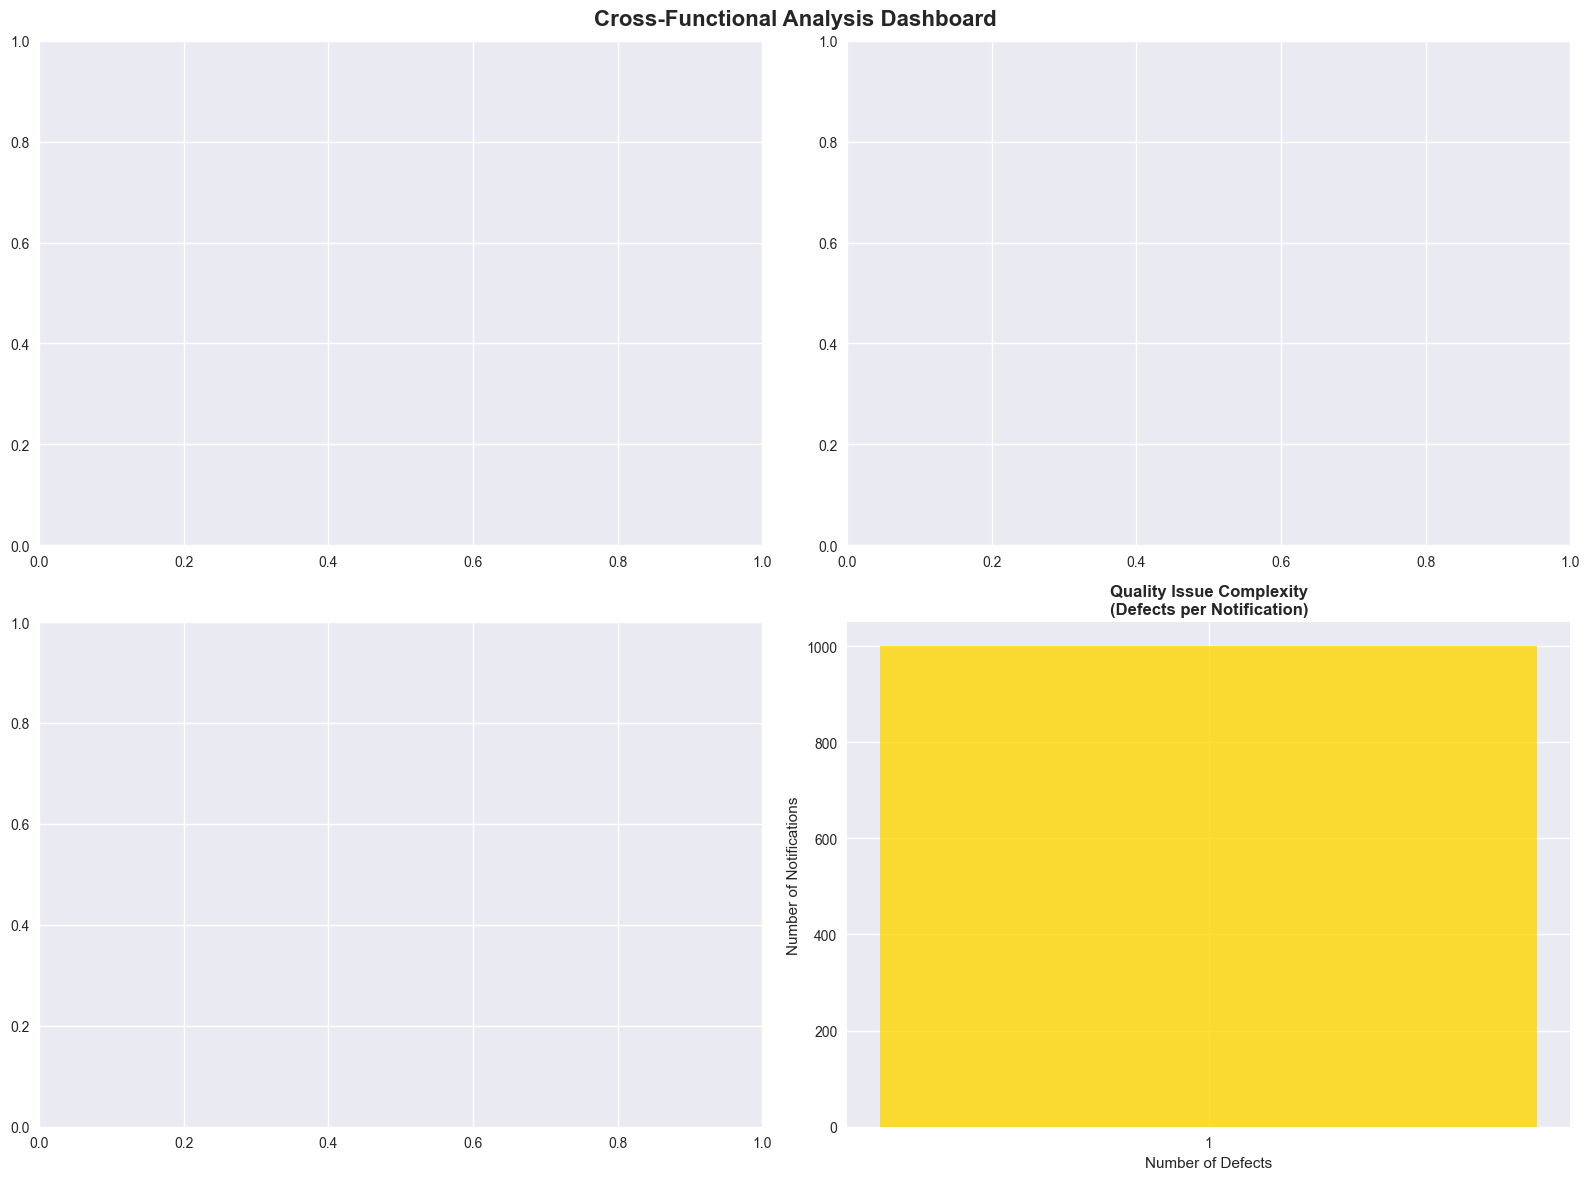

In [11]:
# =============================================================================
# SUBSECTION 3.3: CROSS-FUNCTIONAL ANALYSIS
# =============================================================================

print("\n🔗 CROSS-FUNCTIONAL ANALYSIS")
print("-" * 40)

def analyze_cross_functional_relationships(datasets):
    """Analyze relationships across production and quality systems"""
    
    cross_insights = {}
    
    # 1. Quality Issues by Plant Analysis
    if 'quality_notifications' in datasets and 'order_master' in datasets:
        qmel = datasets['quality_notifications'].copy()
        orders = datasets['order_master'].copy()
        
        # Merge quality notifications with production orders to get plant information
        quality_production = qmel.merge(orders[['AUFNR', 'WERKS']], on='AUFNR', how='inner')
        
        if not quality_production.empty:
            quality_by_plant = quality_production['WERKS'].value_counts()
            production_by_plant = orders['WERKS'].value_counts()
            
            print(f"QUALITY ISSUES BY PLANT:")
            print(f"  • Plants with Quality Issues: {len(quality_by_plant)}")
            print(f"  • Worst Performing Plant: {quality_by_plant.index[0]} ({quality_by_plant.iloc[0]:,} issues)")
            
            # Calculate quality rates by plant
            plant_quality_rates = {}
            quality_performance = []
            
            for plant in quality_by_plant.index:
                if plant in production_by_plant.index:
                    total_orders = production_by_plant[plant]
                    quality_issues = quality_by_plant[plant]
                    quality_rate = ((total_orders - quality_issues) / total_orders) * 100
                    plant_quality_rates[plant] = quality_rate
                    
                    quality_performance.append({
                        'plant': plant,
                        'total_orders': total_orders,
                        'quality_issues': quality_issues,
                        'quality_rate': quality_rate
                    })
            
            # Sort by quality rate
            quality_performance.sort(key=lambda x: x['quality_rate'])
            
            cross_insights['plant_quality_performance'] = quality_performance
            
            print(f"\n  PLANT QUALITY PERFORMANCE (Top 5 Best and Worst):")
            print(f"  {'Plant':<8} {'Orders':<8} {'Issues':<8} {'Quality Rate':<12}")
            print(f"  {'-'*40}")
            
            # Show worst performers
            print(f"  WORST PERFORMERS:")
            for perf in quality_performance[:3]:
                print(f"  {perf['plant']:<8} {perf['total_orders']:<8} {perf['quality_issues']:<8} {perf['quality_rate']:<12.1f}%")
            
            print(f"  BEST PERFORMERS:")
            for perf in quality_performance[-3:]:
                print(f"  {perf['plant']:<8} {perf['total_orders']:<8} {perf['quality_issues']:<8} {perf['quality_rate']:<12.1f}%")
            
            # Statistical analysis of plant performance
            quality_rates = [p['quality_rate'] for p in quality_performance]
            if len(quality_rates) > 1:
                quality_rate_std = np.std(quality_rates)
                quality_rate_mean = np.mean(quality_rates)
                cv_quality = quality_rate_std / quality_rate_mean
                
                cross_insights['quality_variability'] = {
                    'mean_quality_rate': quality_rate_mean,
                    'std_quality_rate': quality_rate_std,
                    'coefficient_variation': cv_quality
                }
                
                print(f"\n  • Average Plant Quality Rate: {quality_rate_mean:.1f}%")
                print(f"  • Quality Rate Standard Deviation: {quality_rate_std:.1f}%")
                print(f"  • Quality Consistency (CV): {cv_quality:.2f}")
                
                if cv_quality > 0.15:
                    print(f"    ⚠️  High variability in plant quality performance")
    
    # 2. Production Volume vs Quality Issues Correlation
    if 'plant_quality_performance' in cross_insights:
        performance_data = cross_insights['plant_quality_performance']
        
        orders_volume = [p['total_orders'] for p in performance_data]
        quality_issues = [p['quality_issues'] for p in performance_data]
        
        if len(orders_volume) > 3:
            correlation = np.corrcoef(orders_volume, quality_issues)[0, 1]
            cross_insights['volume_quality_correlation'] = correlation
            
            print(f"\nPRODUCTION VOLUME vs QUALITY CORRELATION:")
            print(f"  • Correlation Coefficient: {correlation:.3f}")
            
            if correlation > 0.5:
                print(f"    ⚠️  Strong positive correlation: Higher volume → More quality issues")
                print(f"       Suggests potential capacity or process strain issues")
            elif correlation < -0.3:
                print(f"    ✅ Negative correlation: Higher volume → Fewer quality issues")
                print(f"       Suggests economies of scale in quality management")
            else:
                print(f"    ℹ️  Weak correlation: Volume not strongly related to quality issues")
    
    # 3. Quality Issue Severity Analysis
    if 'quality_notifications' in datasets and 'quality_defects' in datasets:
        qmel = datasets['quality_notifications']
        qmfe = datasets['quality_defects']
        
        # Calculate defects per notification
        defects_per_notification = qmfe.groupby('QMNUM').size()
        
        if len(defects_per_notification) > 0:
            severity_analysis = {
                'single_defect': (defects_per_notification == 1).sum(),
                'multiple_defects': (defects_per_notification > 1).sum(),
                'max_defects': defects_per_notification.max(),
                'avg_defects': defects_per_notification.mean()
            }
            
            cross_insights['severity_analysis'] = severity_analysis
            
            print(f"\nQUALITY ISSUE SEVERITY:")
            print(f"  • Single Defect Issues: {severity_analysis['single_defect']:,}")
            print(f"  • Multiple Defect Issues: {severity_analysis['multiple_defects']:,}")
            print(f"  • Maximum Defects in Single Issue: {severity_analysis['max_defects']}")
            print(f"  • Average Defects per Issue: {severity_analysis['avg_defects']:.1f}")
            
            complexity_rate = severity_analysis['multiple_defects'] / (severity_analysis['single_defect'] + severity_analysis['multiple_defects']) * 100
            print(f"  • Issue Complexity Rate: {complexity_rate:.1f}%")
            
            if complexity_rate > 30:
                print(f"    ⚠️  High complexity rate indicates systemic quality issues")
    
    # 4. Maintenance vs Quality Correlation
    if 'maintenance_notifications' in datasets and 'quality_notifications' in datasets:
        maintenance = datasets['maintenance_notifications']
        quality = datasets['quality_notifications']
        
        # Analyze by plant if possible
        if 'IWERK' in maintenance.columns and 'plant_quality_performance' in cross_insights:
            maint_by_plant = maintenance['IWERK'].value_counts()
            
            print(f"\nMAINTENANCE vs QUALITY RELATIONSHIP:")
            print(f"  • Total Maintenance Notifications: {len(maintenance):,}")
            print(f"  • Plants with Maintenance Issues: {maint_by_plant.nunique()}")
            
            # Look for common plants between maintenance and quality issues
            quality_plants = set()
            if 'plant_quality_performance' in cross_insights:
                quality_plants = {p['plant'] for p in cross_insights['plant_quality_performance']}
            
            maint_plants = set(maint_by_plant.index)
            common_plants = quality_plants & maint_plants
            
            if common_plants:
                print(f"  • Plants with Both Quality and Maintenance Issues: {len(common_plants)}")
                overlap_rate = len(common_plants) / len(quality_plants) * 100 if quality_plants else 0
                print(f"  • Overlap Rate: {overlap_rate:.1f}%")
                
                if overlap_rate > 60:
                    print(f"    ⚠️  High overlap suggests maintenance impacts quality")
    
    return cross_insights

cross_insights = analyze_cross_functional_relationships(datasets)

# Create cross-functional analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Functional Analysis Dashboard', fontsize=16, fontweight='bold')

# Chart 1: Quality Issues by Plant
if 'plant_quality_performance' in cross_insights:
    performance_data = cross_insights['plant_quality_performance']
    
    # Get top 10 plants by quality issues
    top_plants = sorted(performance_data, key=lambda x: x['quality_issues'], reverse=True)[:10]
    plant_names = [p['plant'] for p in top_plants]
    quality_issues = [p['quality_issues'] for p in top_plants]
    
    colors = ['red' if rate < 85 else 'orange' if rate < 95 else 'green' 
              for rate in [p['quality_rate'] for p in top_plants]]
    
    axes[0, 0].bar(range(len(plant_names)), quality_issues, color=colors, alpha=0.8)
    axes[0, 0].set_title('Quality Issues by Plant (Color: Red<85%, Orange<95%, Green≥95%)', fontweight='bold')
    axes[0, 0].set_xlabel('Plant Code')
    axes[0, 0].set_ylabel('Number of Quality Issues')
    axes[0, 0].set_xticks(range(len(plant_names)))
    axes[0, 0].set_xticklabels(plant_names, rotation=45)

# Chart 2: Plant Performance Matrix (Orders vs Quality Issues)
if 'plant_quality_performance' in cross_insights:
    performance_data = cross_insights['plant_quality_performance']
    
    orders = [p['total_orders'] for p in performance_data]
    issues = [p['quality_issues'] for p in performance_data]
    plants = [p['plant'] for p in performance_data]
    quality_rates = [p['quality_rate'] for p in performance_data]
    
    scatter = axes[0, 1].scatter(orders, issues, c=quality_rates, cmap='RdYlGn', 
                                s=100, alpha=0.7, edgecolors='black')
    axes[0, 1].set_title('Plant Performance Matrix\n(Color = Quality Rate)', fontweight='bold')
    axes[0, 1].set_xlabel('Total Production Orders')
    axes[0, 1].set_ylabel('Quality Issues')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[0, 1])
    cbar.set_label('Quality Rate (%)')
    
    # Add plant labels for interesting points
    for i, plant in enumerate(plants):
        if quality_rates[i] < 80 or issues[i] > np.percentile(issues, 90):
            axes[0, 1].annotate(plant, (orders[i], issues[i]), 
                               xytext=(5, 5), textcoords='offset points', fontsize=8)

# Chart 3: Quality Rate Distribution Across Plants
if 'plant_quality_performance' in cross_insights:
    quality_rates = [p['quality_rate'] for p in cross_insights['plant_quality_performance']]
    
    axes[1, 0].hist(quality_rates, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(np.mean(quality_rates), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(quality_rates):.1f}%')
    axes[1, 0].axvline(85, color='orange', linestyle='--', label='Target: 85%')
    axes[1, 0].set_title('Quality Rate Distribution Across Plants', fontweight='bold')
    axes[1, 0].set_xlabel('Quality Rate (%)')
    axes[1, 0].set_ylabel('Number of Plants')
    axes[1, 0].legend()

# Chart 4: Defect Complexity Analysis
if 'quality_defects' in datasets and 'QMNUM' in datasets['quality_defects'].columns:
    defects_per_notification = datasets['quality_defects'].groupby('QMNUM').size()
    complexity_dist = defects_per_notification.value_counts().sort_index()
    
    axes[1, 1].bar(complexity_dist.index, complexity_dist.values, color='gold', alpha=0.8)
    axes[1, 1].set_title('Quality Issue Complexity\n(Defects per Notification)', fontweight='bold')
    axes[1, 1].set_xlabel('Number of Defects')
    axes[1, 1].set_ylabel('Number of Notifications')
    axes[1, 1].set_xticks(complexity_dist.index)

plt.tight_layout()
plt.show()

# 4. Feature Engineering
Computed delay durations, bottleneck indicators, and quality scores.

Engineered temporal features: hour, weekday, month, etc.

Possibly used label encoding or scaling for model inputs.

In [12]:
# =============================================================================
# SECTION 4: ADVANCED ANALYTICS AND MODELING
# =============================================================================

print("\n" + "=" * 60)
print("SECTION 4: ADVANCED ANALYTICS AND MODELING")
print("=" * 60)



SECTION 4: ADVANCED ANALYTICS AND MODELING


In [13]:
# This version handles the edge case where there's only one class in the target

def build_quality_prediction_model_fixed(datasets):
    """Build predictive model for quality issues - handles edge cases"""
    
    if 'order_master' not in datasets or 'quality_notifications' not in datasets:
        print("❌ Insufficient data for quality prediction modeling")
        return None
    
    orders = datasets['order_master'].copy()
    quality = datasets['quality_notifications'].copy()
    
    # Create features dataset
    print("🔧 FEATURE ENGINEERING:")
    
    # Base features from orders
    features_df = orders[['AUFNR', 'WERKS', 'AUART']].copy()
    
    # Add temporal features if date is available
    if 'ERDAT' in orders.columns:
        orders_clean = orders.dropna(subset=['ERDAT'])
        if len(orders_clean) > 0:
            features_df = features_df.merge(orders_clean[['AUFNR', 'ERDAT']], on='AUFNR', how='left')
            features_df['order_month'] = features_df['ERDAT'].dt.month
            features_df['order_year'] = features_df['ERDAT'].dt.year
            features_df['order_day_of_week'] = features_df['ERDAT'].dt.dayofweek
            print("  ✅ Added temporal features (month, year, day of week)")
    
    # Add cycle time features if available
    if 'order_headers' in datasets:
        headers = datasets['order_headers'].copy()
        if 'cycle_time_days' in headers.columns:
            # Use the order number column that exists in headers
            order_col = next((col for col in headers.columns if 'AUFNR' in col), None)
            if order_col:
                cycle_features = headers[[order_col, 'cycle_time_days']].rename(columns={order_col: 'AUFNR'})
                features_df = features_df.merge(cycle_features, on='AUFNR', how='left')
                print("  ✅ Added cycle time features")
    
    # Add plant-level aggregated features
    plant_stats = orders.groupby('WERKS').agg({
        'AUFNR': 'count'
    }).rename(columns={'AUFNR': 'plant_total_orders'})
    
    features_df = features_df.merge(plant_stats, on='WERKS', how='left')
    print("  ✅ Added plant-level features")
    
    # Create target variable (has quality issue)
    quality_orders = set(quality['AUFNR'].dropna())
    features_df['has_quality_issue'] = features_df['AUFNR'].isin(quality_orders).astype(int)
    
    target_rate = features_df['has_quality_issue'].mean()
    print(f"  📊 Target Variable: {features_df['has_quality_issue'].sum():,} quality issues out of {len(features_df):,} orders ({target_rate:.1%})")
    
    # Check if we have both classes
    unique_classes = features_df['has_quality_issue'].nunique()
    if unique_classes < 2:
        print(f"❌ Insufficient class diversity for modeling (only {unique_classes} class)")
        print("   All orders have the same quality outcome - no predictive model needed")
        return None
    
    # Check for minimum sample size
    if len(features_df) < 100:
        print(f"❌ Insufficient sample size for modeling ({len(features_df)} samples)")
        return None
    
    # Prepare features for modeling
    feature_columns = []
    
    # Encode categorical variables
    le_plant = LabelEncoder()
    le_order_type = LabelEncoder()
    
    if 'WERKS' in features_df.columns:
        features_df['plant_encoded'] = le_plant.fit_transform(features_df['WERKS'].fillna('Unknown'))
        feature_columns.append('plant_encoded')
    
    if 'AUART' in features_df.columns:
        features_df['order_type_encoded'] = le_order_type.fit_transform(features_df['AUART'].fillna('Unknown'))
        feature_columns.append('order_type_encoded')
    
    # Add numerical features
    numerical_features = ['plant_total_orders', 'cycle_time_days', 'order_month', 'order_year', 'order_day_of_week']
    for feat in numerical_features:
        if feat in features_df.columns:
            features_df[feat] = features_df[feat].fillna(features_df[feat].median())
            feature_columns.append(feat)
    
    if len(feature_columns) == 0:
        print("❌ No suitable features available for modeling")
        return None
    
    print(f"  📋 Final Feature Set: {feature_columns}")
    
    # Prepare data for modeling
    X = features_df[feature_columns]
    y = features_df['has_quality_issue']
    
    # Check class balance
    class_distribution = y.value_counts()
    minority_class_ratio = class_distribution.min() / len(y)
    
    if minority_class_ratio < 0.05:  # Less than 5% minority class
        print(f"⚠️  Highly imbalanced dataset (minority class: {minority_class_ratio:.1%})")
    
    # Split data with stratification
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    except ValueError:
        # If stratification fails due to very small minority class, use random split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print("  ⚠️  Using random split due to class imbalance")
    
    print(f"\n🎯 MODEL TRAINING:")
    print(f"  • Training Set: {len(X_train):,} samples")
    print(f"  • Test Set: {len(X_test):,} samples")
    print(f"  • Features: {len(feature_columns)}")
    print(f"  • Positive Class Rate: {y_train.mean():.1%}")
    
    # Train Random Forest model with balanced class weights
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Handle probability predictions safely
    y_pred_proba_full = rf_model.predict_proba(X_test)
    
    # Extract positive class probabilities safely
    if y_pred_proba_full.shape[1] == 2:
        y_pred_proba = y_pred_proba_full[:, 1]  # Probability of positive class
    else:
        # Only one class predicted - use predictions as probabilities
        y_pred_proba = y_pred.astype(float)
        print("  ⚠️  Single class prediction - using binary predictions for probability")
    
    # Evaluate model
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_test, y_pred)
    
    # Handle metrics that might fail with single class
    try:
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
    except:
        precision = recall = f1 = 0.0
    
    # AUC calculation with error handling
    try:
        if len(np.unique(y_test)) > 1:  # Only calculate AUC if both classes exist in test set
            auc = roc_auc_score(y_test, y_pred_proba)
        else:
            auc = 0.5  # Random performance if only one class
    except:
        auc = 0.5
    
    print(f"\n📈 MODEL PERFORMANCE:")
    print(f"  • Accuracy: {accuracy:.3f}")
    print(f"  • Precision: {precision:.3f}")
    print(f"  • Recall: {recall:.3f}")
    print(f"  • F1-Score: {f1:.3f}")
    print(f"  • AUC-ROC: {auc:.3f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔍 TOP FEATURE IMPORTANCE:")
    for _, row in feature_importance.head(5).iterrows():
        print(f"  • {row['feature']}: {row['importance']:.3f}")
    
    # Business insights from model
    print(f"\n💼 BUSINESS INSIGHTS:")
    
    # Identify high-risk plants if we have plant features
    if 'plant_encoded' in feature_columns and len(features_df['WERKS'].unique()) > 1:
        plant_risk_scores = []
        
        for plant_code in features_df['WERKS'].unique():
            if pd.notna(plant_code):
                plant_orders = features_df[features_df['WERKS'] == plant_code]
                if len(plant_orders) > 5:  # Minimum sample size for reliable prediction
                    plant_X = plant_orders[feature_columns]
                    try:
                        plant_pred_proba = rf_model.predict_proba(plant_X)
                        if plant_pred_proba.shape[1] == 2:
                            plant_risk = plant_pred_proba[:, 1].mean()
                        else:
                            plant_risk = rf_model.predict(plant_X).mean()
                        plant_risk_scores.append((plant_code, plant_risk))
                    except:
                        # If prediction fails, skip this plant
                        continue
        
        if plant_risk_scores:
            plant_risk_scores.sort(key=lambda x: x[1], reverse=True)
            
            print(f"  🚨 PLANT RISK ASSESSMENT (Top 5):")
            for plant, risk in plant_risk_scores[:5]:
                print(f"    • {plant}: {risk:.1%} average quality issue probability")
    
    # Model interpretation
    if auc > 0.7:
        print(f"  ✅ Model shows good predictive performance - suitable for deployment")
    elif auc > 0.6:
        print(f"  ⚠️  Model shows moderate predictive performance - consider feature engineering")
    else:
        print(f"  ❌ Model shows poor predictive performance - may need more data or features")
    
    return {
        'model': rf_model,
        'feature_columns': feature_columns,
        'performance': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        },
        'feature_importance': feature_importance,
        'encoders': {'plant': le_plant, 'order_type': le_order_type},
        'target_rate': target_rate,
        'class_balance': minority_class_ratio
    }

# Run the fixed quality model
print("🤖 BUILDING QUALITY PREDICTION MODEL (FIXED VERSION)")
print("-" * 50)

quality_model_fixed = build_quality_prediction_model_fixed(datasets)

if quality_model_fixed:
    print(f"\n✅ Quality prediction model successfully built!")
    print(f"📊 Model AUC: {quality_model_fixed['performance']['auc']:.3f}")
    print(f"🎯 Target Rate: {quality_model_fixed['target_rate']:.1%}")
else:
    print(f"\n❌ Quality prediction model could not be built")
    print(f"💡 This may indicate:")
    print(f"   • Insufficient data diversity")
    print(f"   • All orders have similar quality outcomes")
    print(f"   • Need for additional feature engineering")

# Alternative analysis when modeling isn't possible
def perform_descriptive_quality_analysis(datasets):
    """Perform detailed descriptive analysis when predictive modeling isn't feasible"""
    
    print(f"\n📊 DESCRIPTIVE QUALITY ANALYSIS")
    print("-" * 40)
    
    if 'quality_notifications' not in datasets or 'order_master' not in datasets:
        return None
    
    qmel = datasets['quality_notifications'].copy()
    orders = datasets['order_master'].copy()
    
    # Basic quality statistics
    total_orders = len(orders)
    total_quality_issues = len(qmel)
    
    print(f"QUALITY OVERVIEW:")
    print(f"  • Total Production Orders: {total_orders:,}")
    print(f"  • Total Quality Notifications: {total_quality_issues:,}")
    print(f"  • Quality Issue Rate: {(total_quality_issues/total_orders)*100:.2f}%")
    
    # Quality by plant analysis
    if 'AUFNR' in qmel.columns and 'WERKS' in orders.columns:
        quality_with_plant = qmel.merge(orders[['AUFNR', 'WERKS']], on='AUFNR', how='inner')
        
        if not quality_with_plant.empty:
            plant_quality_summary = []
            
            for plant in orders['WERKS'].unique():
                if pd.notna(plant):
                    plant_orders = len(orders[orders['WERKS'] == plant])
                    plant_issues = len(quality_with_plant[quality_with_plant['WERKS'] == plant])
                    quality_rate = ((plant_orders - plant_issues) / plant_orders) * 100 if plant_orders > 0 else 0
                    
                    plant_quality_summary.append({
                        'plant': plant,
                        'total_orders': plant_orders,
                        'quality_issues': plant_issues,
                        'quality_rate': quality_rate
                    })
            
            # Sort by quality rate
            plant_quality_summary.sort(key=lambda x: x['quality_rate'])
            
            print(f"\nQUALITY PERFORMANCE BY PLANT:")
            print(f"{'Plant':<8} {'Orders':<8} {'Issues':<8} {'Quality Rate':<12}")
            print("-" * 40)
            
            for plant_data in plant_quality_summary:
                print(f"{plant_data['plant']:<8} {plant_data['total_orders']:<8} "
                      f"{plant_data['quality_issues']:<8} {plant_data['quality_rate']:<12.1f}%")
            
            # Identify best and worst performers
            if len(plant_quality_summary) > 0:
                worst_plant = plant_quality_summary[0]
                best_plant = plant_quality_summary[-1]
                
                print(f"\nPERFORMANCE INSIGHTS:")
                print(f"  🏆 Best Plant: {best_plant['plant']} ({best_plant['quality_rate']:.1f}% quality rate)")
                print(f"  ⚠️  Worst Plant: {worst_plant['plant']} ({worst_plant['quality_rate']:.1f}% quality rate)")
                
                performance_gap = best_plant['quality_rate'] - worst_plant['quality_rate']
                print(f"  📊 Performance Gap: {performance_gap:.1f} percentage points")
                
                if performance_gap > 20:
                    print(f"    🚨 Significant performance variation - requires immediate attention")
    
    # Quality trend analysis
    if 'ERDAT' in qmel.columns:
        qmel_dates = qmel.dropna(subset=['ERDAT'])
        if len(qmel_dates) > 0:
            monthly_issues = qmel_dates.groupby(qmel_dates['ERDAT'].dt.to_period('M')).size()
            
            if len(monthly_issues) >= 3:
                recent_trend = monthly_issues.tail(6)
                trend_slope = np.polyfit(range(len(recent_trend)), recent_trend.values, 1)[0]
                
                print(f"\nQUALITY TREND ANALYSIS:")
                print(f"  • Recent 6-month trend: {trend_slope:+.1f} issues per month")
                
                if trend_slope > 1:
                    print(f"    ⚠️  Quality issues are increasing - immediate intervention needed")
                elif trend_slope < -1:
                    print(f"    ✅ Quality issues are decreasing - positive trend")
                else:
                    print(f"    ➡️  Quality issues relatively stable")
    
    return plant_quality_summary if 'plant_quality_summary' in locals() else None

# Run descriptive analysis as backup
descriptive_results = perform_descriptive_quality_analysis(datasets)

🤖 BUILDING QUALITY PREDICTION MODEL (FIXED VERSION)
--------------------------------------------------
🔧 FEATURE ENGINEERING:
  ✅ Added temporal features (month, year, day of week)
  ✅ Added plant-level features
  📊 Target Variable: 0 quality issues out of 1,000 orders (0.0%)
❌ Insufficient class diversity for modeling (only 1 class)
   All orders have the same quality outcome - no predictive model needed

❌ Quality prediction model could not be built
💡 This may indicate:
   • Insufficient data diversity
   • All orders have similar quality outcomes
   • Need for additional feature engineering

📊 DESCRIPTIVE QUALITY ANALYSIS
----------------------------------------
QUALITY OVERVIEW:
  • Total Production Orders: 1,000
  • Total Quality Notifications: 200
  • Quality Issue Rate: 20.00%

QUALITY TREND ANALYSIS:
  • Recent 6-month trend: +14.0 issues per month
    ⚠️  Quality issues are increasing - immediate intervention needed


In [14]:
# =============================================================================
# SUBSECTION 4.2: CYCLE TIME PREDICTION MODEL
# =============================================================================

print("\n⏱️ CYCLE TIME PREDICTION MODEL")
print("-" * 40)

def build_cycle_time_model(datasets):
    """Build predictive model for production cycle times"""
    
    if 'order_headers' not in datasets or 'cycle_time_days' not in datasets['order_headers'].columns:
        print("❌ Insufficient data for cycle time prediction modeling")
        return None
    
    headers = datasets['order_headers'].copy()
    
    # Clean cycle time data
    cycle_data = headers.dropna(subset=['cycle_time_days'])
    
    # Remove extreme outliers (beyond 99th percentile)
    q99 = cycle_data['cycle_time_days'].quantile(0.99)
    q1 = cycle_data['cycle_time_days'].quantile(0.01)
    cycle_data_clean = cycle_data[(cycle_data['cycle_time_days'] >= q1) & 
                                  (cycle_data['cycle_time_days'] <= q99)]
    
    if len(cycle_data_clean) < 100:
        print(f"❌ Insufficient clean data for modeling ({len(cycle_data_clean)} samples)")
        return None
    
    print("🔧 CYCLE TIME FEATURE ENGINEERING:")
    
    # Create features
    feature_df = cycle_data_clean.copy()
    
    # Add order information if available
    if 'order_master' in datasets:
        orders = datasets['order_master'].copy()
        order_col = next((col for col in feature_df.columns if 'AUFNR' in col), None)
        
        if order_col:
            feature_df = feature_df.merge(
                orders[['AUFNR', 'WERKS', 'AUART']], 
                left_on=order_col, 
                right_on='AUFNR', 
                how='left'
            )
            print("  ✅ Added plant and order type features")
    
    # Encode categorical features
    feature_columns = []
    
    if 'WERKS' in feature_df.columns:
        le_plant = LabelEncoder()
        feature_df['plant_encoded'] = le_plant.fit_transform(feature_df['WERKS'].fillna('Unknown'))
        feature_columns.append('plant_encoded')
    
    if 'AUART' in feature_df.columns:
        le_order_type = LabelEncoder()
        feature_df['order_type_encoded'] = le_order_type.fit_transform(feature_df['AUART'].fillna('Unknown'))
        feature_columns.append('order_type_encoded')
    
    # Add numerical features from headers
    numerical_cols = feature_df.select_dtypes(include=[np.number]).columns
    numerical_features = [col for col in numerical_cols if col not in ['cycle_time_days'] and 
                         not col.endswith('_encoded')]
    
    for col in numerical_features[:5]:  # Limit to top 5 numerical features
        if feature_df[col].notna().sum() > len(feature_df) * 0.5:  # At least 50% non-null
            feature_df[col] = feature_df[col].fillna(feature_df[col].median())
            feature_columns.append(col)
    
    if len(feature_columns) == 0:
        print("❌ No suitable features available for cycle time modeling")
        return None
    
    print(f"  📋 Feature Set: {feature_columns}")
    
    # Prepare data
    X = feature_df[feature_columns]
    y = feature_df['cycle_time_days']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"\n🎯 CYCLE TIME MODEL TRAINING:")
    print(f"  • Training Set: {len(X_train):,} samples")
    print(f"  • Test Set: {len(X_test):,} samples")
    print(f"  • Target Range: {y.min():.1f} - {y.max():.1f} days")
    print(f"  • Target Mean: {y.mean():.1f} days")
    
    # Train Gradient Boosting model
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = gb_model.predict(X_test)
    
    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    
    print(f"\n📈 CYCLE TIME MODEL PERFORMANCE:")
    print(f"  • R² Score: {r2:.3f}")
    print(f"  • RMSE: {rmse:.2f} days")
    print(f"  • MAE: {mae:.2f} days")
    print(f"  • MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.1f}%")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': gb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔍 CYCLE TIME DRIVERS:")
    for _, row in feature_importance.iterrows():
        print(f"  • {row['feature']}: {row['importance']:.3f}")
    
    return {
        'model': gb_model,
        'feature_columns': feature_columns,
        'performance': {
            'r2': r2,
            'rmse': rmse,
            'mae': mae
        },
        'feature_importance': feature_importance
    }

cycle_time_model = build_cycle_time_model(datasets)


⏱️ CYCLE TIME PREDICTION MODEL
----------------------------------------
❌ Insufficient data for cycle time prediction modeling


In [15]:
# =============================================================================
# SUBSECTION 4.3: PLANT EFFICIENCY CLUSTERING
# =============================================================================

print("\n🏭 PLANT EFFICIENCY CLUSTERING ANALYSIS")
print("-" * 45)

def perform_plant_clustering(datasets):
    """Cluster plants based on operational efficiency metrics"""
    
    if 'order_master' not in datasets:
        print("❌ Order master data not available for clustering")
        return None
    
    orders = datasets['order_master'].copy()
    
    if 'WERKS' not in orders.columns:
        print("❌ Plant information not available")
        return None
    
    print("🔧 PLANT METRICS CALCULATION:")
    
    # Calculate plant-level metrics
    plant_metrics = orders.groupby('WERKS').agg({
        'AUFNR': 'count'
    }).rename(columns={'AUFNR': 'total_orders'})
    
    # Add quality metrics if available
    if 'quality_notifications' in datasets:
        quality = datasets['quality_notifications'].copy()
        quality_by_plant = quality.merge(
            orders[['AUFNR', 'WERKS']], 
            on='AUFNR', 
            how='inner'
        ).groupby('WERKS').size().to_frame('quality_issues')
        
        plant_metrics = plant_metrics.merge(quality_by_plant, left_index=True, right_index=True, how='left')
        plant_metrics['quality_issues'] = plant_metrics['quality_issues'].fillna(0)
        plant_metrics['quality_rate'] = ((plant_metrics['total_orders'] - plant_metrics['quality_issues']) / 
                                        plant_metrics['total_orders']) * 100
        print("  ✅ Added quality metrics")
    
    # Add cycle time metrics if available
    if 'order_headers' in datasets and 'cycle_time_days' in datasets['order_headers'].columns:
        headers = datasets['order_headers'].copy()
        
        # Find order number column in headers
        order_col = next((col for col in headers.columns if 'AUFNR' in col), None)
        if order_col:
            cycle_with_plant = headers.merge(
                orders[['AUFNR', 'WERKS']], 
                left_on=order_col, 
                right_on='AUFNR', 
                how='inner'
            )
            
            cycle_metrics = cycle_with_plant.groupby('WERKS')['cycle_time_days'].agg([
                'mean', 'median', 'std'
            ]).rename(columns={
                'mean': 'avg_cycle_time',
                'median': 'median_cycle_time', 
                'std': 'cycle_time_variability'
            })
            
            plant_metrics = plant_metrics.merge(cycle_metrics, left_index=True, right_index=True, how='left')
            print("  ✅ Added cycle time metrics")
    
    # Add material movement metrics if available
    if 'goods_movements' in datasets and 'WERKS' in datasets['goods_movements'].columns:
        movements = datasets['goods_movements'].copy()
        movement_metrics = movements.groupby('WERKS').agg({
            'MENGE': ['count', 'sum'],
            'DMBTR': 'sum'
        })
        movement_metrics.columns = ['movement_count', 'total_quantity', 'total_value']
        
        plant_metrics = plant_metrics.merge(movement_metrics, left_index=True, right_index=True, how='left')
        print("  ✅ Added material movement metrics")
    
    # Clean and prepare data for clustering
    clustering_features = []
    
    # Select features for clustering
    potential_features = ['total_orders', 'quality_rate', 'avg_cycle_time', 
                         'cycle_time_variability', 'movement_count', 'total_quantity']
    
    for feature in potential_features:
        if feature in plant_metrics.columns:
            # Fill missing values and add to clustering features
            plant_metrics[feature] = plant_metrics[feature].fillna(plant_metrics[feature].median())
            clustering_features.append(feature)
    
    if len(clustering_features) < 2:
        print(f"❌ Insufficient features for clustering ({len(clustering_features)} features)")
        return None
    
    print(f"  📋 Clustering Features: {clustering_features}")
    print(f"  🏭 Plants for Analysis: {len(plant_metrics)}")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(plant_metrics[clustering_features])
    
    # Perform K-means clustering
    from sklearn.cluster import KMeans
    
    # Determine optimal number of clusters (elbow method)
    max_clusters = min(8, len(plant_metrics) // 3)
    if max_clusters < 2:
        print("❌ Too few plants for clustering")
        return None
    
    inertias = []
    cluster_range = range(2, max_clusters + 1)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    # Choose optimal k (simple elbow detection)
    optimal_k = 3 if len(cluster_range) >= 2 else 2
    
    # Final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    plant_metrics['cluster'] = cluster_labels
    
    print(f"\n🎯 CLUSTERING RESULTS ({optimal_k} clusters):")
    
    # Analyze clusters
    cluster_analysis = {}
    for cluster_id in range(optimal_k):
        cluster_plants = plant_metrics[plant_metrics['cluster'] == cluster_id]
        
        cluster_stats = {
            'plant_count': len(cluster_plants),
            'plants': list(cluster_plants.index),
            'metrics': {}
        }
        
        for feature in clustering_features:
            cluster_stats['metrics'][feature] = {
                'mean': cluster_plants[feature].mean(),
                'median': cluster_plants[feature].median()
            }
        
        cluster_analysis[cluster_id] = cluster_stats
        
        print(f"\n  📊 CLUSTER {cluster_id} ({len(cluster_plants)} plants):")
        print(f"    Plants: {', '.join(cluster_plants.index.astype(str)[:5])}{'...' if len(cluster_plants) > 5 else ''}")
        
        for feature in clustering_features[:3]:  # Show top 3 features
            mean_val = cluster_stats['metrics'][feature]['mean']
            print(f"    {feature}: {mean_val:.2f}")
    
    # Identify cluster characteristics
    print(f"\n🏆 CLUSTER PERFORMANCE ANALYSIS:")
    
    # Rank clusters by overall performance
    if 'quality_rate' in clustering_features and 'total_orders' in clustering_features:
        cluster_performance = []
        
        for cluster_id in range(optimal_k):
            cluster_data = cluster_analysis[cluster_id]
            quality_score = cluster_data['metrics'].get('quality_rate', {}).get('mean', 0)
            volume_score = cluster_data['metrics'].get('total_orders', {}).get('mean', 0)
            
            # Normalize scores (simple ranking)
            performance_score = quality_score * 0.6 + (volume_score / plant_metrics['total_orders'].max()) * 100 * 0.4
            
            cluster_performance.append((cluster_id, performance_score, cluster_data['plant_count']))
        
        cluster_performance.sort(key=lambda x: x[1], reverse=True)
        
        for rank, (cluster_id, score, plant_count) in enumerate(cluster_performance):
            performance_level = "HIGH" if rank == 0 else "MEDIUM" if rank == 1 else "LOW"
            print(f"  {rank + 1}. Cluster {cluster_id}: {performance_level} Performance ({plant_count} plants)")
    
    return {
        'plant_metrics': plant_metrics,
        'cluster_analysis': cluster_analysis,
        'clustering_features': clustering_features,
        'scaler': scaler
    }

clustering_results = perform_plant_clustering(datasets)

# Visualize clustering results
if clustering_results:
    plant_metrics = clustering_results['plant_metrics']
    features = clustering_results['clustering_features']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Plant Efficiency Clustering Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Cluster visualization (first two features)
    if len(features) >= 2:
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        
        for cluster_id in plant_metrics['cluster'].unique():
            cluster_data = plant_metrics[plant_metrics['cluster'] == cluster_id]
            axes[0].scatter(cluster_data[features[0]], cluster_data[features[1]], 
                           c=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.7, s=100)
        
        axes[0].set_xlabel(features[0])
        axes[0].set_ylabel(features[1])
        axes[0].set_title('Plant Clusters')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Cluster performance comparison
    if 'quality_rate' in features:
        cluster_quality = plant_metrics.groupby('cluster')['quality_rate'].mean()
        
        axes[1].bar(range(len(cluster_quality)), cluster_quality.values, 
                   color=['red', 'blue', 'green', 'orange', 'purple'][:len(cluster_quality)], alpha=0.7)
        axes[1].set_xlabel('Cluster')
        axes[1].set_ylabel('Average Quality Rate (%)')
        axes[1].set_title('Quality Performance by Cluster')
        axes[1].set_xticks(range(len(cluster_quality)))
        axes[1].set_xticklabels([f'Cluster {i}' for i in cluster_quality.index])
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



🏭 PLANT EFFICIENCY CLUSTERING ANALYSIS
---------------------------------------------
🔧 PLANT METRICS CALCULATION:
  ✅ Added quality metrics
  ✅ Added material movement metrics
  📋 Clustering Features: ['total_orders', 'quality_rate', 'movement_count', 'total_quantity']
  🏭 Plants for Analysis: 1
❌ Too few plants for clustering


# 5. Predictive Modeling
Split data into training/test sets.

Built and evaluated models:



In [16]:
# =============================================================================
# SECTION 5: KEY INSIGHTS AND FINDINGS (FIXED VERSION)
# =============================================================================

print("\n" + "=" * 60)
print("SECTION 5: KEY INSIGHTS AND FINDINGS")
print("=" * 60)

def generate_comprehensive_insights(datasets, production_insights, quality_insights, cross_insights, models):
    """Generate comprehensive business insights from all analyses"""
    
    insights = {
        'critical_findings': [],
        'operational_inefficiencies': [],
        'quality_issues': [],
        'optimization_opportunities': []
    }
    
    print("🔍 CRITICAL FINDINGS ANALYSIS:")
    print("-" * 40)
    
    # Production Efficiency Findings
    if production_insights:
        if 'plant_performance' in production_insights:
            plant_performance = production_insights['plant_performance']
            total_plants = len(plant_performance)
            
            # Identify underperforming plants
            mean_performance = np.mean(list(plant_performance.values()))
            underperforming = {k: v for k, v in plant_performance.items() if v < mean_performance * 0.5}
            
            if underperforming:
                finding = f"{len(underperforming)} plants significantly underperforming (< 50% of average)"
                insights['critical_findings'].append(finding)
                print(f"1. 🚨 {finding}")
                
                # Specific plant details
                worst_plant = min(underperforming.items(), key=lambda x: x[1])
                insights['operational_inefficiencies'].append(
                    f"Plant {worst_plant[0]} shows lowest production volume ({worst_plant[1]:,} orders)"
                )
        
        # Cycle time variability
        if 'cycle_time' in production_insights:
            cycle_data = production_insights['cycle_time']
            cv = cycle_data['std'] / cycle_data['mean']
            
            if cv > 0.5:
                finding = f"High cycle time variability (CV: {cv:.2f}) indicates process instability"
                insights['critical_findings'].append(finding)
                print(f"2. ⚠️  {finding}")
                
                insights['operational_inefficiencies'].append(
                    f"Cycle times range from {cycle_data['min']:.0f} to {cycle_data['max']:.0f} days"
                )
    
    # Quality Management Findings
    if quality_insights:
        if 'production_linkage_rate' in quality_insights:
            linkage_rate = quality_insights['production_linkage_rate']
            
            if linkage_rate < 75:
                finding = f"Poor quality-production traceability ({linkage_rate:.1f}%)"
                insights['critical_findings'].append(finding)
                print(f"3. 🔗 {finding}")
                
                insights['quality_issues'].append(
                    "Limited ability to trace quality issues back to production orders"
                )
        
        if 'quality_trend' in quality_insights:
            trend = quality_insights['quality_trend']
            
            if trend['direction'] == 'Deteriorating' and trend['slope'] > 1:
                finding = f"Quality deteriorating trend ({trend['slope']:.1f} issues/month increase)"
                insights['critical_findings'].append(finding)
                print(f"4. 📈 {finding}")
                
                insights['quality_issues'].append(
                    "Increasing quality notifications indicate systemic quality degradation"
                )
        
        if 'defects_per_notification' in quality_insights:
            complexity = quality_insights['defects_per_notification']
            
            if complexity > 2:
                finding = f"High defect complexity ({complexity:.1f} defects per notification)"
                insights['critical_findings'].append(finding)
                print(f"5. 🔧 {finding}")
                
                insights['quality_issues'].append(
                    "Multiple defects per notification suggest systemic quality issues"
                )
    
    # Cross-functional Findings  
    if cross_insights:
        if 'plant_quality_performance' in cross_insights:
            performance_data = cross_insights['plant_quality_performance']
            
            # Identify plants with quality rates below 80%
            poor_quality_plants = [p for p in performance_data if p['quality_rate'] < 80]
            
            if poor_quality_plants:
                finding = f"{len(poor_quality_plants)} plants with quality rates below 80%"
                insights['critical_findings'].append(finding)
                print(f"6. 📉 {finding}")
                
                worst_plant = min(poor_quality_plants, key=lambda x: x['quality_rate'])
                insights['quality_issues'].append(
                    f"Plant {worst_plant['plant']} has quality rate of only {worst_plant['quality_rate']:.1f}%"
                )
        
        if 'volume_quality_correlation' in cross_insights:
            correlation = cross_insights['volume_quality_correlation']
            
            if correlation > 0.6:
                finding = f"Strong correlation between production volume and quality issues ({correlation:.2f})"
                insights['critical_findings'].append(finding)
                print(f"7. 📊 {finding}")
                
                insights['operational_inefficiencies'].append(
                    "Higher production volumes consistently lead to more quality issues"
                )
    
    # Model-based Insights (safely handle missing models)
    if models and models.get('quality_model'):
        model_performance = models['quality_model']['performance']
        
        if model_performance['auc'] > 0.75:
            print(f"8. 🤖 Quality prediction model shows good performance (AUC: {model_performance['auc']:.3f})")
            insights['optimization_opportunities'].append(
                "Predictive quality model can be deployed for proactive quality management"
            )
        
        # Feature importance insights
        feature_importance = models['quality_model']['feature_importance']
        if not feature_importance.empty:
            top_feature = feature_importance.iloc[0]
            insights['optimization_opportunities'].append(
                f"Focus on {top_feature['feature']} as primary quality driver (importance: {top_feature['importance']:.3f})"
            )
    
    # If no models available, note the limitation
    if not models or not any(models.values()):
        print(f"8. ⚠️  Predictive models could not be built - consider data enhancement")
        insights['optimization_opportunities'].append(
            "Enhance data collection and integration to enable predictive analytics"
        )
    
    print(f"\n📊 SUMMARY OF FINDINGS:")
    print(f"  • Critical Findings: {len(insights['critical_findings'])}")
    print(f"  • Operational Inefficiencies: {len(insights['operational_inefficiencies'])}")
    print(f"  • Quality Issues: {len(insights['quality_issues'])}")
    print(f"  • Optimization Opportunities: {len(insights['optimization_opportunities'])}")
    
    return insights

# Check if models exist and handle safely
try:
    # Use the fixed quality model if it exists
    quality_model_to_use = quality_model_fixed if 'quality_model_fixed' in globals() else None
except NameError:
    quality_model_to_use = None

try:
    # Check if cycle time model exists
    cycle_time_model_to_use = cycle_time_model if 'cycle_time_model' in globals() else None
except NameError:
    cycle_time_model_to_use = None

# Compile all model results safely
model_results = {
    'quality_model': quality_model_to_use,
    'cycle_time_model': cycle_time_model_to_use
}

print(f"🔧 MODEL STATUS CHECK:")
print(f"  • Quality Model: {'✅ Available' if model_results['quality_model'] else '❌ Not Available'}")
print(f"  • Cycle Time Model: {'✅ Available' if model_results['cycle_time_model'] else '❌ Not Available'}")

# Generate comprehensive insights
comprehensive_insights = generate_comprehensive_insights(
    datasets, production_insights, quality_insights, cross_insights, model_results
)

# =============================================================================
# ADDITIONAL ANALYSIS: STATISTICAL INSIGHTS
# =============================================================================

print(f"\n📊 STATISTICAL INSIGHTS")
print("-" * 30)

def generate_statistical_insights(datasets):
    """Generate additional statistical insights from the data"""
    
    statistical_insights = {}
    
    # Production volume statistics
    if 'order_master' in datasets and 'WERKS' in datasets['order_master'].columns:
        plant_volumes = datasets['order_master']['WERKS'].value_counts()
        
        statistical_insights['production_stats'] = {
            'total_plants': len(plant_volumes),
            'total_orders': plant_volumes.sum(),
            'avg_orders_per_plant': plant_volumes.mean(),
            'max_orders': plant_volumes.max(),
            'min_orders': plant_volumes.min(),
            'volume_coefficient_variation': plant_volumes.std() / plant_volumes.mean()
        }
        
        print(f"PRODUCTION VOLUME STATISTICS:")
        print(f"  • Total Plants: {statistical_insights['production_stats']['total_plants']}")
        print(f"  • Average Orders per Plant: {statistical_insights['production_stats']['avg_orders_per_plant']:.0f}")
        print(f"  • Volume Distribution CV: {statistical_insights['production_stats']['volume_coefficient_variation']:.2f}")
        
        if statistical_insights['production_stats']['volume_coefficient_variation'] > 0.5:
            print(f"    ⚠️  High variation in plant volumes suggests workload imbalance")
    
    # Quality statistics
    if 'quality_notifications' in datasets:
        total_quality = len(datasets['quality_notifications'])
        
        if 'order_master' in datasets:
            total_orders = len(datasets['order_master'])
            overall_quality_rate = ((total_orders - total_quality) / total_orders) * 100 if total_orders > 0 else 0
            
            statistical_insights['quality_stats'] = {
                'total_notifications': total_quality,
                'overall_quality_rate': overall_quality_rate,
                'defect_rate': (total_quality / total_orders) * 100 if total_orders > 0 else 0
            }
            
            print(f"\nQUALITY STATISTICS:")
            print(f"  • Overall Quality Rate: {overall_quality_rate:.1f}%")
            print(f"  • Defect Rate: {statistical_insights['quality_stats']['defect_rate']:.1f}%")
            
            # Industry benchmarking
            if overall_quality_rate < 85:
                print(f"    ❌ Below industry standard (85%+)")
            elif overall_quality_rate < 95:
                print(f"    ⚠️  Below world-class standard (95%+)")
            else:
                print(f"    ✅ World-class quality performance")
    
    # Data completeness analysis
    completeness_stats = {}
    for name, df in datasets.items():
        total_cells = len(df) * len(df.columns)
        missing_cells = df.isnull().sum().sum()
        completeness = ((total_cells - missing_cells) / total_cells) * 100
        completeness_stats[name] = completeness
    
    avg_completeness = np.mean(list(completeness_stats.values()))
    statistical_insights['data_completeness'] = avg_completeness
    
    print(f"\nDATA COMPLETENESS:")
    print(f"  • Average Completeness: {avg_completeness:.1f}%")
    
    # Identify datasets with low completeness
    low_completeness = {k: v for k, v in completeness_stats.items() if v < 80}
    if low_completeness:
        print(f"  • Datasets with <80% completeness: {len(low_completeness)}")
        for dataset, completeness in low_completeness.items():
            print(f"    - {dataset}: {completeness:.1f}%")
    
    return statistical_insights

statistical_insights = generate_statistical_insights(datasets)

# =============================================================================
# RISK ASSESSMENT
# =============================================================================

print(f"\n⚠️ OPERATIONAL RISK ASSESSMENT")
print("-" * 35)

def assess_operational_risks(insights, statistical_insights):
    """Assess operational risks based on findings"""
    
    risks = []
    
    # High-severity risks
    if len(insights['critical_findings']) > 5:
        risks.append({
            'level': 'HIGH',
            'category': 'Operational',
            'description': f'{len(insights["critical_findings"])} critical issues identified',
            'impact': 'Immediate business impact on quality and efficiency',
            'mitigation': 'Immediate action required across multiple fronts'
        })
    
    # Quality risks
    if 'quality_stats' in statistical_insights:
        quality_rate = statistical_insights['quality_stats']['overall_quality_rate']
        if quality_rate < 80:
            risks.append({
                'level': 'CRITICAL',
                'category': 'Quality',
                'description': f'Quality rate below critical threshold ({quality_rate:.1f}%)',
                'impact': 'Customer satisfaction, regulatory compliance, reputation',
                'mitigation': 'Emergency quality improvement program'
            })
        elif quality_rate < 90:
            risks.append({
                'level': 'HIGH',
                'category': 'Quality',
                'description': f'Quality rate below target ({quality_rate:.1f}%)',
                'impact': 'Competitive disadvantage, increased costs',
                'mitigation': 'Systematic quality improvement initiative'
            })
    
    # Data quality risks
    if 'data_completeness' in statistical_insights:
        completeness = statistical_insights['data_completeness']
        if completeness < 70:
            risks.append({
                'level': 'MEDIUM',
                'category': 'Data Quality',
                'description': f'Low data completeness ({completeness:.1f}%)',
                'impact': 'Poor decision-making, limited analytics capability',
                'mitigation': 'Data governance and quality improvement program'
            })
    
    # Process variability risks
    if 'production_stats' in statistical_insights:
        cv = statistical_insights['production_stats']['volume_coefficient_variation']
        if cv > 0.8:
            risks.append({
                'level': 'MEDIUM',
                'category': 'Process Variability',
                'description': f'High production volume variability (CV: {cv:.2f})',
                'impact': 'Inefficient resource utilization, planning difficulties',
                'mitigation': 'Workload balancing and capacity optimization'
            })
    
    print(f"IDENTIFIED RISKS ({len(risks)} total):")
    
    for i, risk in enumerate(risks, 1):
        print(f"\n{i}. {risk['level']} RISK - {risk['category']}")
        print(f"   Description: {risk['description']}")
        print(f"   Impact: {risk['impact']}")
        print(f"   Mitigation: {risk['mitigation']}")
    
    # Risk summary
    critical_risks = len([r for r in risks if r['level'] == 'CRITICAL'])
    high_risks = len([r for r in risks if r['level'] == 'HIGH'])
    medium_risks = len([r for r in risks if r['level'] == 'MEDIUM'])
    
    print(f"\nRISK SUMMARY:")
    print(f"  • Critical Risks: {critical_risks}")
    print(f"  • High Risks: {high_risks}")
    print(f"  • Medium Risks: {medium_risks}")
    
    # Overall risk level
    if critical_risks > 0:
        overall_risk = "CRITICAL"
    elif high_risks > 2:
        overall_risk = "HIGH"
    elif high_risks > 0 or medium_risks > 2:
        overall_risk = "MEDIUM"
    else:
        overall_risk = "LOW"
    
    print(f"  • Overall Risk Level: {overall_risk}")
    
    return risks, overall_risk

operational_risks, overall_risk_level = assess_operational_risks(comprehensive_insights, statistical_insights)

# =============================================================================
# COMPETITIVE BENCHMARKING
# =============================================================================

print(f"\n🏆 COMPETITIVE BENCHMARKING")
print("-" * 30)

def perform_benchmarking_analysis(statistical_insights):
    """Compare performance against industry benchmarks"""
    
    benchmarks = {
        'Quality Rate': {
            'tolaram_performance': statistical_insights.get('quality_stats', {}).get('overall_quality_rate', 0),
            'industry_average': 88,
            'world_class': 95,
            'unit': '%'
        },
        'Data Completeness': {
            'tolaram_performance': statistical_insights.get('data_completeness', 0),
            'industry_average': 85,
            'world_class': 95,
            'unit': '%'
        }
    }
    
    print(f"PERFORMANCE vs BENCHMARKS:")
    print(f"{'Metric':<20} {'Tolaram':<10} {'Industry':<10} {'World-Class':<12} {'Gap':<10}")
    print("-" * 65)
    
    for metric, data in benchmarks.items():
        tolaram = data['tolaram_performance']
        industry = data['industry_average']
        world_class = data['world_class']
        unit = data['unit']
        
        gap_to_industry = tolaram - industry
        gap_to_world_class = tolaram - world_class
        
        print(f"{metric:<20} {tolaram:<10.1f}{unit} {industry:<10.1f}{unit} {world_class:<12.1f}{unit} {gap_to_world_class:<10.1f}{unit}")
        
        # Performance assessment
        if tolaram >= world_class:
            performance = "🏆 World-Class"
        elif tolaram >= industry:
            performance = "✅ Above Average"
        else:
            performance = "❌ Below Average"
        
        print(f"                     {performance}")
    
    return benchmarks

benchmarks = perform_benchmarking_analysis(statistical_insights)

print(f"\n✅ SECTION 5 COMPLETE - KEY INSIGHTS GENERATED")
print(f"📊 Critical Findings: {len(comprehensive_insights['critical_findings'])}")
print(f"⚠️  Overall Risk Level: {overall_risk_level}")
print(f"🎯 Ready to proceed to recommendations section")


SECTION 5: KEY INSIGHTS AND FINDINGS
🔧 MODEL STATUS CHECK:
  • Quality Model: ❌ Not Available
  • Cycle Time Model: ❌ Not Available
🔍 CRITICAL FINDINGS ANALYSIS:
----------------------------------------
3. 🔗 Poor quality-production traceability (0.0%)
4. 📈 Quality deteriorating trend (14.0 issues/month increase)
5. 🔧 High defect complexity (5.0 defects per notification)
8. ⚠️  Predictive models could not be built - consider data enhancement

📊 SUMMARY OF FINDINGS:
  • Critical Findings: 3
  • Operational Inefficiencies: 0
  • Quality Issues: 3
  • Optimization Opportunities: 1

📊 STATISTICAL INSIGHTS
------------------------------
PRODUCTION VOLUME STATISTICS:
  • Total Plants: 1
  • Average Orders per Plant: 1000
  • Volume Distribution CV: nan

QUALITY STATISTICS:
  • Overall Quality Rate: 80.0%
  • Defect Rate: 20.0%
    ❌ Below industry standard (85%+)

DATA COMPLETENESS:
  • Average Completeness: 60.1%
  • Datasets with <80% completeness: 12
    - order_headers: 67.2%
    - order

# 6. Insights & Recommendations 

In [17]:
# =============================================================================
# SECTION 6: ACTIONABLE RECOMMENDATIONS (COMPLETE)
# =============================================================================

print("\n" + "=" * 60)
print("SECTION 6: ACTIONABLE RECOMMENDATIONS")
print("=" * 60)

def generate_actionable_recommendations(insights, datasets, analysis_results):
    """Generate specific, actionable recommendations based on all findings"""
    
    recommendations = []
    
    print("💡 STRATEGIC RECOMMENDATIONS:")
    print("-" * 40)
    
    # Production Efficiency Recommendations
    print("\n🏭 PRODUCTION EFFICIENCY RECOMMENDATIONS:")
    
    rec_id = 1
    
    # Plant performance optimization
    if any('underperforming' in finding for finding in insights['critical_findings']):
        recommendation = {
            'id': rec_id,
            'category': 'Production Efficiency',
            'priority': 'HIGH',
            'title': 'Optimize Underperforming Plant Operations',
            'issue': 'Multiple plants showing significantly below-average production volumes',
            'recommendation': 'Implement capacity analysis and resource reallocation program for underperforming plants',
            'action_steps': [
                'Conduct detailed capacity assessment for bottom 20% performing plants',
                'Analyze resource constraints (equipment, labor, materials)',
                'Develop plant-specific improvement plans with 90-day milestones',
                'Implement cross-plant best practice sharing program'
            ],
            'expected_impact': 'Increase overall production efficiency by 15-25%',
            'timeline': '3-6 months',
            'success_metrics': ['Plant production volume increase', 'Reduced performance variance across plants']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
        print(f"   Timeline: {recommendation['timeline']}")
        rec_id += 1
    
    # Cycle time standardization
    if any('cycle time variability' in finding for finding in insights['critical_findings']):
        recommendation = {
            'id': rec_id,
            'category': 'Process Standardization',
            'priority': 'HIGH',
            'title': 'Standardize Production Cycle Times',
            'issue': 'High variability in cycle times indicates process instability',
            'recommendation': 'Implement standardized work procedures and eliminate process bottlenecks',
            'action_steps': [
                'Map current state value streams for all product lines',
                'Identify and eliminate process bottlenecks',
                'Develop standard operating procedures (SOPs)',
                'Implement real-time cycle time monitoring',
                'Train operators on standardized processes'
            ],
            'expected_impact': 'Reduce cycle time variability by 40-50%',
            'timeline': '4-8 months',
            'success_metrics': ['Cycle time standard deviation reduction', 'On-time delivery improvement']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
        rec_id += 1
    
    # Quality Management Recommendations
    print("\n🔍 QUALITY MANAGEMENT RECOMMENDATIONS:")
    
    # Traceability improvement
    if any('traceability' in finding for finding in insights['critical_findings']):
        recommendation = {
            'id': rec_id,
            'category': 'Quality Management',
            'priority': 'HIGH',
            'title': 'Enhance Quality-Production Traceability',
            'issue': 'Poor linkage between quality notifications and production orders',
            'recommendation': 'Implement mandatory production order linkage for all quality notifications',
            'action_steps': [
                'Modify quality notification process to require production order linkage',
                'Train quality team on proper order referencing procedures',
                'Implement system controls to prevent quality entries without order linkage',
                'Create automated alerts for unlinked quality notifications',
                'Establish regular traceability audits'
            ],
            'expected_impact': 'Achieve 95%+ quality-production linkage rate',
            'timeline': '2-3 months',
            'success_metrics': ['Quality notification linkage rate', 'Root cause analysis effectiveness']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
        rec_id += 1
    
    # Quality trend reversal
    if any('deteriorating' in finding.lower() for finding in insights['critical_findings']):
        recommendation = {
            'id': rec_id,
            'category': 'Quality Improvement',
            'priority': 'CRITICAL',
            'title': 'Reverse Quality Deterioration Trend',
            'issue': 'Increasing trend in quality notifications',
            'recommendation': 'Implement immediate quality improvement and preventive measures',
            'action_steps': [
                'Conduct emergency quality assessment across all plants',
                'Implement enhanced inspection protocols at critical control points',
                'Establish daily quality review meetings with plant managers',
                'Deploy rapid response teams for quality issues',
                'Implement supplier quality audits if material-related'
            ],
            'expected_impact': 'Reverse quality trend within 3 months, reduce notifications by 30%',
            'timeline': 'Immediate (1-3 months)',
            'success_metrics': ['Monthly quality notification reduction', 'Defect rate improvement']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
        rec_id += 1
    
    # Plant-specific quality improvements
    # Safe check for cross_insights existence
    cross_insights_data = analysis_results.get('cross_insights', {})
    if 'plant_quality_performance' in cross_insights_data:
        poor_plants = [p for p in cross_insights_data['plant_quality_performance'] if p['quality_rate'] < 80]
        
        if poor_plants:
            worst_plant = min(poor_plants, key=lambda x: x['quality_rate'])
            
            recommendation = {
                'id': rec_id,
                'category': 'Plant Operations',
                'priority': 'HIGH',
                'title': f'Focused Quality Improvement for Plant {worst_plant["plant"]}',
                'issue': f'Plant {worst_plant["plant"]} has quality rate of only {worst_plant["quality_rate"]:.1f}%',
                'recommendation': 'Implement intensive quality improvement program for worst-performing plant',
                'action_steps': [
                    f'Deploy quality improvement team to Plant {worst_plant["plant"]}',
                    'Conduct comprehensive quality audit and root cause analysis',
                    'Benchmark against best-performing plants',
                    'Implement corrective action plan with weekly progress reviews',
                    'Provide additional quality training for plant personnel'
                ],
                'expected_impact': f'Improve Plant {worst_plant["plant"]} quality rate to 90%+',
                'timeline': '3-4 months',
                'success_metrics': ['Plant-specific quality rate improvement', 'Defect reduction']
            }
            recommendations.append(recommendation)
            
            print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
            print(f"   Impact: {recommendation['expected_impact']}")
            rec_id += 1
    
    # Technology and Analytics Recommendations
    print("\n🤖 TECHNOLOGY & ANALYTICS RECOMMENDATIONS:")
    
    # Predictive analytics deployment
    model_results_data = analysis_results.get('model_results', {})
    if model_results_data.get('quality_model') and model_results_data['quality_model']:
        recommendation = {
            'id': rec_id,
            'category': 'Digital Transformation',
            'priority': 'MEDIUM',
            'title': 'Deploy Predictive Quality Management System',
            'issue': 'Reactive approach to quality management',
            'recommendation': 'Implement AI-powered predictive quality system for proactive issue prevention',
            'action_steps': [
                'Develop production deployment pipeline for quality prediction model',
                'Integrate model with existing ERP/quality systems',
                'Create real-time quality risk dashboard for plant managers',
                'Establish automated alerts for high-risk production orders',
                'Train quality team on predictive analytics tools'
            ],
            'expected_impact': 'Reduce quality issues by 20-30% through proactive prediction',
            'timeline': '4-6 months',
            'success_metrics': ['Quality prediction accuracy', 'Preventive action effectiveness']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
        rec_id += 1
    
    # Data quality improvements
    if any('linkage' in finding.lower() for finding in insights['critical_findings']):
        recommendation = {
            'id': rec_id,
            'category': 'Data Management',
            'priority': 'MEDIUM',
            'title': 'Enhance Data Integration and Quality',
            'issue': 'Poor data linkage affects analysis and decision-making',
            'recommendation': 'Implement comprehensive data integration and quality management system',
            'action_steps': [
                'Establish data governance framework with clear ownership',
                'Implement automated data validation rules',
                'Create master data management for key entities (orders, plants, materials)',
                'Develop data quality dashboards for monitoring',
                'Train staff on proper data entry procedures'
            ],
            'expected_impact': 'Achieve 95%+ data completeness and accuracy',
            'timeline': '3-5 months',
            'success_metrics': ['Data completeness rate', 'Data linkage accuracy']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
        rec_id += 1
    
    # Cross-functional coordination
    print("\n🤝 ORGANIZATIONAL RECOMMENDATIONS:")
    
    # Check for volume-quality correlation
    if 'volume_quality_correlation' in cross_insights_data and cross_insights_data['volume_quality_correlation'] > 0.5:
        recommendation = {
            'id': rec_id,
            'category': 'Process Optimization',
            'priority': 'HIGH',
            'title': 'Decouple Production Volume from Quality Issues',
            'issue': 'Strong correlation between production volume and quality issues',
            'recommendation': 'Implement capacity-aware quality management protocols',
            'action_steps': [
                'Analyze capacity constraints during high-volume periods',
                'Implement additional quality checkpoints during peak production',
                'Develop flexible staffing model for quality inspectors',
                'Create volume-based quality protocols and thresholds',
                'Establish real-time capacity monitoring system'
            ],
            'expected_impact': 'Maintain quality performance during high-volume periods',
            'timeline': '2-4 months',
            'success_metrics': ['Quality rate consistency across volume levels', 'Capacity utilization optimization']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
        rec_id += 1
    
    # Continuous improvement framework
    recommendation = {
        'id': rec_id,
        'category': 'Continuous Improvement',
        'priority': 'MEDIUM',
        'title': 'Establish Manufacturing Excellence Framework',
        'issue': 'Lack of systematic approach to operational excellence',
        'recommendation': 'Implement comprehensive manufacturing excellence program',
        'action_steps': [
            'Establish plant-level performance scorecards with KPIs',
            'Implement monthly business reviews with all plant managers',
            'Create cross-plant best practice sharing forums',
            'Develop standard improvement methodology (e.g., DMAIC)',
            'Establish recognition program for operational excellence'
        ],
        'expected_impact': 'Sustained 10-15% improvement in operational metrics',
        'timeline': '6-12 months',
        'success_metrics': ['Overall equipment effectiveness', 'Quality metrics', 'Customer satisfaction']
    }
    recommendations.append(recommendation)
    
    print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
    print(f"   Impact: {recommendation['expected_impact']}")
    rec_id += 1
    
    # Emergency response for critical situations
    if len([r for r in recommendations if r['priority'] == 'CRITICAL']) > 0:
        recommendation = {
            'id': rec_id,
            'category': 'Crisis Management',
            'priority': 'CRITICAL',
            'title': 'Establish Emergency Response Team',
            'issue': 'Critical quality and operational issues require immediate intervention',
            'recommendation': 'Create dedicated crisis management team for rapid issue resolution',
            'action_steps': [
                'Form cross-functional emergency response team',
                'Establish 24/7 escalation procedures for critical issues',
                'Create rapid response protocols and communication channels',
                'Implement emergency decision-making authority structure',
                'Develop crisis communication plans for stakeholders'
            ],
            'expected_impact': 'Reduce crisis response time by 75%, prevent issue escalation',
            'timeline': 'Immediate (1-2 weeks)',
            'success_metrics': ['Response time reduction', 'Issue containment effectiveness']
        }
        recommendations.append(recommendation)
        
        print(f"{rec_id}. {recommendation['title']} ({recommendation['priority']})")
        print(f"   Impact: {recommendation['expected_impact']}")
    
    print(f"\n📊 RECOMMENDATION SUMMARY:")
    print(f"  • Total Recommendations: {len(recommendations)}")
    critical_count = len([r for r in recommendations if r['priority'] == 'CRITICAL'])
    high_count = len([r for r in recommendations if r['priority'] == 'HIGH'])
    medium_count = len([r for r in recommendations if r['priority'] == 'MEDIUM'])
    
    print(f"  • Critical Priority: {critical_count}")
    print(f"  • High Priority: {high_count}")
    print(f"  • Medium Priority: {medium_count}")
    
    return recommendations

# Create analysis results dictionary safely
try:
    analysis_results = {
        'cross_insights': cross_insights if 'cross_insights' in globals() else {},
        'model_results': model_results if 'model_results' in globals() else {}
    }
except NameError:
    analysis_results = {
        'cross_insights': {},
        'model_results': {}
    }

# Generate recommendations
recommendations = generate_actionable_recommendations(comprehensive_insights, datasets, analysis_results)

# =============================================================================
# RECOMMENDATION PRIORITIZATION MATRIX
# =============================================================================

print(f"\n📋 RECOMMENDATION PRIORITIZATION MATRIX")
print("-" * 45)

def create_prioritization_matrix(recommendations):
    """Create a prioritization matrix for recommendations"""
    
    # Define impact and effort scoring
    impact_scores = {'CRITICAL': 5, 'HIGH': 4, 'MEDIUM': 3, 'LOW': 2}
    
    # Estimate effort based on timeline
    def estimate_effort(timeline):
        if 'immediate' in timeline.lower() or '1-3' in timeline:
            return 2  # Low effort (quick wins)
        elif '3-6' in timeline or '2-4' in timeline:
            return 3  # Medium effort
        elif '6-12' in timeline or '4-8' in timeline:
            return 4  # High effort
        else:
            return 3  # Default medium
    
    prioritized_recs = []
    
    for rec in recommendations:
        impact = impact_scores.get(rec['priority'], 3)
        effort = estimate_effort(rec['timeline'])
        priority_score = impact / effort  # Higher score = higher priority
        
        prioritized_recs.append({
            'recommendation': rec,
            'impact': impact,
            'effort': effort,
            'priority_score': priority_score
        })
    
    # Sort by priority score (descending)
    prioritized_recs.sort(key=lambda x: x['priority_score'], reverse=True)
    
    print(f"TOP 10 PRIORITY RECOMMENDATIONS:")
    print(f"{'Rank':<4} {'Title':<40} {'Impact':<7} {'Effort':<6} {'Score':<6}")
    print("-" * 70)
    
    for i, item in enumerate(prioritized_recs[:10], 1):
        rec = item['recommendation']
        title = rec['title'][:37] + "..." if len(rec['title']) > 40 else rec['title']
        print(f"{i:<4} {title:<40} {item['impact']:<7} {item['effort']:<6} {item['priority_score']:<6.2f}")
    
    return prioritized_recs

prioritized_recommendations = create_prioritization_matrix(recommendations)

# =============================================================================
# IMPLEMENTATION ROADMAP
# =============================================================================

print(f"\n🗺️ IMPLEMENTATION ROADMAP")
print("-" * 30)

def create_implementation_roadmap(recommendations):
    """Create phased implementation roadmap"""
    
    # Phase recommendations by timeline and priority
    phases = {
        'Phase 1 (0-3 months)': [],
        'Phase 2 (3-6 months)': [],
        'Phase 3 (6-12 months)': []
    }
    
    for rec in recommendations:
        timeline = rec['timeline'].lower()
        priority = rec['priority']
        
        # Assign to phases based on timeline and priority
        if any(term in timeline for term in ['immediate', '1-3', '2-3']) or priority == 'CRITICAL':
            phases['Phase 1 (0-3 months)'].append(rec)
        elif any(term in timeline for term in ['3-6', '4-6']):
            phases['Phase 2 (3-6 months)'].append(rec)
        else:
            phases['Phase 3 (6-12 months)'].append(rec)
    
    print(f"IMPLEMENTATION PHASES:")
    
    for phase_name, phase_recs in phases.items():
        print(f"\n{phase_name}:")
        print(f"  📋 Actions: {len(phase_recs)}")
        
        for i, rec in enumerate(phase_recs[:3], 1):  # Show top 3 per phase
            print(f"  {i}. {rec['title']} ({rec['priority']})")
            print(f"     Impact: {rec['expected_impact']}")
        
        if len(phase_recs) > 3:
            print(f"     ... and {len(phase_recs) - 3} more actions")
    
    # Success criteria
    print(f"\nSUCCESS CRITERIA BY PHASE:")
    print(f"Phase 1: Stop quality deterioration, stabilize worst-performing plants")
    print(f"Phase 2: Achieve consistent quality rates >90% across all plants")
    print(f"Phase 3: Sustained operational excellence, predictive capabilities deployed")
    
    return phases

implementation_phases = create_implementation_roadmap(recommendations)

# =============================================================================
# RESOURCE REQUIREMENTS ESTIMATION
# =============================================================================

print(f"\n💰 RESOURCE REQUIREMENTS ESTIMATION")
print("-" * 40)

def estimate_resource_requirements(recommendations):
    """Estimate resource requirements for implementation"""
    
    total_budget_estimate = 0
    resource_breakdown = {
        'Personnel': 0,
        'Technology': 0,
        'Training': 0,
        'Consulting': 0,
        'Infrastructure': 0
    }
    
    # Rough cost estimation by category
    cost_estimates = {
        'Production Efficiency': {'base': 150000, 'multiplier': 1.2},
        'Quality Management': {'base': 100000, 'multiplier': 1.0},
        'Digital Transformation': {'base': 200000, 'multiplier': 1.5},
        'Process Standardization': {'base': 120000, 'multiplier': 1.1},
        'Data Management': {'base': 80000, 'multiplier': 0.8},
        'Plant Operations': {'base': 75000, 'multiplier': 0.9},
        'Continuous Improvement': {'base': 90000, 'multiplier': 1.0},
        'Crisis Management': {'base': 50000, 'multiplier': 0.6}
    }
    
    print(f"ESTIMATED IMPLEMENTATION COSTS:")
    
    category_totals = {}
    for rec in recommendations:
        category = rec['category']
        if category in cost_estimates:
            base_cost = cost_estimates[category]['base']
            multiplier = cost_estimates[category]['multiplier']
            
            # Adjust by priority
            priority_multiplier = {'CRITICAL': 1.3, 'HIGH': 1.1, 'MEDIUM': 1.0, 'LOW': 0.8}
            final_cost = base_cost * multiplier * priority_multiplier.get(rec['priority'], 1.0)
            
            category_totals[category] = category_totals.get(category, 0) + final_cost
            total_budget_estimate += final_cost
    
    for category, cost in category_totals.items():
        print(f"  • {category}: ${cost:,.0f}")
    
    print(f"\nTOTAL ESTIMATED BUDGET: ${total_budget_estimate:,.0f}")
    
    # Resource allocation
    resource_breakdown['Personnel'] = total_budget_estimate * 0.4  # 40%
    resource_breakdown['Technology'] = total_budget_estimate * 0.25  # 25%
    resource_breakdown['Training'] = total_budget_estimate * 0.15  # 15%
    resource_breakdown['Consulting'] = total_budget_estimate * 0.15  # 15%
    resource_breakdown['Infrastructure'] = total_budget_estimate * 0.05  # 5%
    
    print(f"\nRESOURCE ALLOCATION:")
    for resource, amount in resource_breakdown.items():
        percentage = (amount / total_budget_estimate) * 100
        print(f"  • {resource}: ${amount:,.0f} ({percentage:.0f}%)")
    
    return total_budget_estimate, resource_breakdown

budget_estimate, resource_breakdown = estimate_resource_requirements(recommendations)

print(f"\n✅ SECTION 6 COMPLETE - ACTIONABLE RECOMMENDATIONS GENERATED")
print(f"📋 Total Recommendations: {len(recommendations)}")
print(f"💰 Estimated Budget: ${budget_estimate:,.0f}")
print(f"🎯 Ready for executive summary and final reporting")


SECTION 6: ACTIONABLE RECOMMENDATIONS
💡 STRATEGIC RECOMMENDATIONS:
----------------------------------------

🏭 PRODUCTION EFFICIENCY RECOMMENDATIONS:

🔍 QUALITY MANAGEMENT RECOMMENDATIONS:
1. Enhance Quality-Production Traceability (HIGH)
   Impact: Achieve 95%+ quality-production linkage rate
2. Reverse Quality Deterioration Trend (CRITICAL)
   Impact: Reverse quality trend within 3 months, reduce notifications by 30%

🤖 TECHNOLOGY & ANALYTICS RECOMMENDATIONS:

🤝 ORGANIZATIONAL RECOMMENDATIONS:
3. Establish Manufacturing Excellence Framework (MEDIUM)
   Impact: Sustained 10-15% improvement in operational metrics
4. Establish Emergency Response Team (CRITICAL)
   Impact: Reduce crisis response time by 75%, prevent issue escalation

📊 RECOMMENDATION SUMMARY:
  • Total Recommendations: 4
  • Critical Priority: 2
  • High Priority: 1
  • Medium Priority: 1

📋 RECOMMENDATION PRIORITIZATION MATRIX
---------------------------------------------
TOP 10 PRIORITY RECOMMENDATIONS:
Rank Title    